# Arloesiadur industrial analysis notebook

## Inputs:
* Data tables with information about business counts (IDBR) and employment (BRES)
* Assorted metadata

## Activities
* Load and process data
* Convert LAD metrics to TTWAS

## Outputs
* Data tables for AHRC

## Preamble

In [1]:
#Magic
%matplotlib inline

#Utilities
import os
import warnings
import requests
import json
import datetime
import pickle

#Numeric
import numpy as np
import scipy
from scipy.stats import zscore
import pandas as pd
import itertools as itr #for cartesian product
import random #to draw random elements from list

#Plotting
import matplotlib.pyplot as plt

#ml
from sklearn import preprocessing
from sklearn import multiclass, ensemble, svm, linear_model, naive_bayes
from sklearn import model_selection, grid_search
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score,average_precision_score, f1_score, accuracy_score, label_ranking_average_precision_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, recall_score
from sklearn.externals import joblib
from sklearn.exceptions import UndefinedMetricWarning

#Spatial
import pysal


#Directories
dir_path = os.path.dirname(os.getcwd())
ex_data_path = os.path.join(dir_path,'data/external')
int_data_path = os.path.join(dir_path,'data/interim')
fig_path = os.path.join(dir_path,'reports/figures')
proc_data_path = os.path.join(dir_path,'data/processed')

#Warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=UndefinedMetricWarning)


#Date for saving files 
tod = datetime.date.today()
today = "_".join([str(x) for x in [tod.year,tod.month,tod.day]])

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Classes

class Complexify():
    '''
    This class takes a df where rows = industries and columns = industries 
    and performs operations on it to extract information about the complexity of 
    its locations and the uniqueness of its industries

    '''
    def __init__(self,df):
        '''
        We will initialise the class with a dataframe.
        '''
        self.df = df

    def create_lq(self):
        area_activity = self.df.sum(axis=0)
        area_shares = area_activity/area_activity.sum()
        
        lqs = self.df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
        self.lqmat = lqs
        
        return(lqs)

    def get_complexity(self,iterations=14,spec_threshold=0.8):
        '''
        This methods produces a binary RCA matrix and extracts its complexity.
        It returns a vector with all the iterations of the method of reflections
        
        '''
        #Create binary matrix
        rca = self.create_lq().applymap(lambda x: 1 if x>spec_threshold else 0)
        
        compl = eci_algorithm_simplified(rca,iterations)
        
        #This is the output of the reflections methods with all its operations
        return(compl)
        
    def get_econ_complexity(self,iterations=14,spec_threshold=0.8):
        '''
        This methods returns the economic complexity of all locations in the DF.
        
        '''
        
        compl = self.get_complexity(iterations,spec_threshold=spec_threshold)
        
        #This looks for the right index in the outptus from the reflections method,
        #given that economic complexity is an even iteration in the 0-index output from the reflections method
        
        if iterations % 2 == 0:
            it = iterations
        else:
            it = iterations
        
        #Need to do some transformations to normalise the outputs
        
        #return(compl[it][0])
        return(pd.Series(zscore(compl[it][0]),index=self.df.index,name='lad_compl'))
    
    def get_sector_uniqueness(self,iterations=14,spec_threshold=0.8):
        
        compl = self.get_complexity(iterations,spec_threshold=spec_threshold)
        
        #...and sector uniqueness is an odd iteration in the 1-index output from the reflections method
        
        if iterations % 2 == 0:
            it = iterations
        else:
            it = iterations
        
        #return(compl[it-1][1])
        return(pd.Series(zscore(compl[it-1][1]),index=self.df.columns,name='sec_uniq'))
              # .apply(lambda x: zscore(x)))

#Class for the exploratory analysis before prediction

class GetHistoricalCorrelations():
    '''
    This class takes two lists with the same length.
    gain measures gains in specialisation by lad and sector between 2 periods while init looks at 
    the situation in the initial period. Take into account sequencing when including these two variables
    in the analysis.
    
    The methods include:
    -corr_yoy, which returns a list with vectorised correlations between the elements in the lists.
    -corr_avg, which averages correlations by sector and lad over different years.
    -heatmap, which gives us a heatmap to visualise the outptus of corr_avg
    '''
    
    def __init__(self,gain,init):
        '''
        initialise with those two lists
        
        '''
        self.gain = gain
        self.init = init
    
    def corr_yoy(self):
        '''
        This method applies the corr_gain_init method to the elements in the 2 input lists, by pairs.
        
        '''
        def corr_gain_init(df_t0,df_t1):
            '''
            This method correlates the columns of one dataframe with the columns of another
            '''
            cont = pd.DataFrame(index=[x+'_gain' for x in df_t1.columns],columns=[str(x)+'_initial' for x in df_t0.columns])

            for i in np.arange(len(cont.index)):
                for j in np.arange(len(cont.columns)):
                    cor = df_t1.iloc[:,i].corr(df_t0.iloc[:,j])
                    cont.iloc[i,j]=cor
            return(cont)
    
                
        correlates = [corr_gain_init(x,y) for x,y in zip(self.init,self.gain)]
        self.correlates = correlates
    
    def corr_avg(self):
        '''
        This method averages the dfs in correlates
        
        '''
        #Obtain the correlates
        self.corr_yoy()
        
        correlates_to_average = pd.concat([pd.melt(
            x.reset_index(drop=False),id_vars='index').set_index(
            ['index','variable']) for x in self.correlates],axis=1).mean(axis=1)

        average_corrs = pd.pivot_table(correlates_to_average.reset_index(drop=False),
                                       index='index',columns='variable',values=0)

        
        self.avg_mat = average_corrs
    
    def heatmap(self,fs=(15,10)):
        '''
        Plots a heatmap
        '''
        
        self.corr_avg()
        
        average_corr = self.avg_mat.copy()
        
        average_corr = average_corr.ix[reversed(average_corr.index),average_corr.columns]
        
        fig,ax = plt.subplots(1,figsize=fs)

        x = np.arange(0,len(average_corr.columns)+1)
        y = np.arange(0,len(average_corr)+1)


        #ax.set_xlim((0,5))

        X,Y = np.meshgrid(x,y)

        Z = np.array(average_corr)

        im = ax.pcolormesh(X,Y,Z,cmap=plt.get_cmap('seismic'),alpha=0.6)


        ax.set_xticks([y+0.5 for y in x[:-1]])
        ax.set_xticklabels(average_corr.columns,size=7,rotation=90)

        ax.set_yticks([x+0.5 for x in y[:-1]])

        ax.set_yticklabels(average_corr.index,size=7)

        plt.colorbar(im)

        ax.set_title('Average correlation in activity t0-t1, 2010-2015')

#Class to evaluate model performance
class ModelPerformance():
    '''
    This class takes a dict with feature sets and generates an output with performance outcomes for those sets
    
    '''
    
    def __init__(self,feature_dict,Y):
        '''
        Initialise the class with a feature dict.
        
        '''
    
        self.features_set = feature_dict
        self.Y = Y
        
        #Also initialises the models we will use
    
    def fit_evaluate(self):
        '''
        Fit models and extract performance
        
        '''
        
        Y = self.Y
        
        
        log_clf_2 = multiclass.OneVsRestClassifier(linear_model.LogisticRegressionCV())
        nb_clf = multiclass.OneVsRestClassifier(naive_bayes.GaussianNB())
        rf_clf = multiclass.OneVsRestClassifier(ensemble.RandomForestClassifier())

        #Create feature sets for each type of model.
        #Logistic
        log_clf_pars_list = [[1,10,15],['balanced',None]]
        log_clf_combs = list(itr.product(log_clf_pars_list[0],log_clf_pars_list[1]))

        #Random forests
        rf_pars_list = [[10,15,20],[1,5,10],['balanced',None]]
        rf_clf_combs = list(itr.product(rf_pars_list[0],rf_pars_list[1],rf_pars_list[2]))

        #Naive bayes
        #Has no hyperparameters

        #Set the scoring metric.
        aps = make_scorer(f1_score,average='weighted')    
        #aps = make_scorer(,'weighted')
        
        #This is a container for the results of the analysis
        cont = []

        #We run through the dict with the datasets
        for i in self.features_set.keys():

            #Extract X from the dict
            X = self.features_set[i]

            #Work with Naive Bayes model
            #Update on progress
            print('training nb model {x}'.format(x=i))

            scores = cross_val_score(nb_clf,X,Y,cv=3,scoring=aps)
            cont.append([i,'nb',scores.mean()])

            #Work with log model
            for n,j in enumerate(log_clf_combs):

                #Update us on progress
                print('training log model {x} run {y}'.format(x=i,y=n))

                #Set parameters for the estimator
                log_clf_2.set_params(estimator__Cs=j[0],estimator__class_weight=j[1])

                #Run cross validation
                scores = cross_val_score(log_clf_2,X,Y,cv=3,scoring=aps)

                #Extract results with i = feature set, hyper parameters and mean scores
                res = [i,'log',j[0],j[1],scores.mean()]
                cont.append(res)

            #Work with RF model
            for n,j in enumerate(rf_clf_combs):

                #Update us on progress
                print('training rf model {x} run {y}'.format(x=i,y=n))

                #Set parameters for the estimator
                rf_clf.set_params(estimator__n_estimators=j[0],
                                  estimator__min_samples_leaf=j[1],
                                  estimator__class_weight=j[2])

                #Run cross validation
                scores = cross_val_score(rf_clf,X,Y,cv=3,scoring=aps)

                #Extract results with i = feature set, hyper parameters and mean scores
                res = [i,'rf',j[0],j[1],j[2],scores.mean()]
                cont.append(res)
        
        self.results = cont
        
        
        #What are the best performing models in each specification?

        #Create a dict with the models
        model_list = [{x[1]:x} for x in cont]


        best_scores = []

        models = ['nb','rf','log']

        for i in models:
            #Get the model results


            model_results = [x[i] for x in model_list if list(x.keys())[0]==i]

            #Get the maximum.
            scores = [x[-1] for x in model_results]
            #print(scores)
            max_index = scores.index(max(scores))

            #print(model_results[max_index])
            best_scores.append(model_results[max_index])
        
        self.best_scores = best_scores                
        
    def fit_model(self,model_params):
        '''
        Fits a model based on a list with feature set and parameters.
        We can for example use this to fit the best models extracted from evaluation process above.
        
        '''
        
        Y = self.Y
        
        model = {}
        features = {}
        for pars in model_params:
            if 'nb' in pars:
                
                X = self.features_set[pars[0]]
                
                #Naive bayes
                nb_clf = multiclass.OneVsRestClassifier(naive_bayes.GaussianNB())
                nb_clf.fit(X,Y)
                model['nb'] = nb_clf
                features['nb'] = X
        
            elif 'log' in pars:
                #Logistic
                
                X = self.features_set[pars[0]]
                
                log_clf_2 = multiclass.OneVsRestClassifier(linear_model.LogisticRegressionCV())
                log_clf_2.set_params(estimator__Cs=pars[2], estimator__class_weight=pars[3]) 
                log_clf_2.fit(X,Y)
                model['log'] = log_clf_2
                features['log'] = X

        
            else:
                #Random forest
                
                X = self.features_set[pars[0]]
                
                rf_clf = multiclass.OneVsRestClassifier(ensemble.RandomForestClassifier())
                rf_clf.set_params(estimator__n_estimators=pars[2],
                                  estimator__min_samples_leaf=pars[3],
                                  estimator__class_weight=pars[4])
                rf_clf.fit(X,Y)
                model['rf'] = rf_clf
                features['rf'] = X
                
        #Random forests
        self.fitted_models = model
        self.fitted_features = features
        
    def make_prediction(self,model,features,indices,columns):
        '''
        Input a model, output and features, returns 2 dfs with predicted probabilities and the actuals
    
        '''    
        
        #Extract predicted probabilities
        predict_proba = model.predict_proba(features)
        
        #Generate outputs.
        
        predict_df = pd.DataFrame(predict_proba,index=indices,columns=columns)
        
        #self.pred_outputs = predict_df
        return(predict_df)
        
        #return([Y,predict_df])
        

    
class ModelEvaluation():
    '''
    This class extracts and plots confusion matrices for a model, and precision-recall curves.
    
    '''
    
    def __init__(self,model,Y,X):
        '''
        Key inputs - the model we are using, its inputs and its outputs.
        
        '''
        
        self.model = model
        self.Y = Y
        self.X = X
    
    def get_confusion_matrix_sector(self,labels):
        '''
    
        This function takes returns df with confusion matrix results for each sector 
        We also need to supply labels for the index.

        '''

        #Generate predictions
        Y = self.Y
        preds = self.model.predict(self.X)


        #We loop over the columns of actuals and predicted. NB they *should* have the same dimensions 
        cmatrices = [confusion_matrix(Y[:,x],
                                      preds[:,x]) for x in np.arange(Y.shape[1])]
        
        #Now we have the confusion matrices for each category.
        #Put them in a dataframe
        conf_df = pd.concat([pd.DataFrame({'tp':x[1,1],'tn':x[0,0],'fn':x[1,0],'fp':x[0,1]},index=[num]) for num,x in 
                                           enumerate(cmatrices)])


        conf_df.index = labels
        conf_df = conf_df.apply(lambda x: x/x.sum(),axis=1)

        conf_df['precision'] = conf_df.tp + conf_df.tn
        
        conf_df = conf_df.sort_values('precision',ascending=False)
        
        self.confusion_sector = conf_df
    
    def get_confusion_matrix_local(self,labels,years=3):
        '''
        
        In this case we need to loop over the rows to get the outputs by lad
        
        '''
        
        #Load targets and generate predictions
        Y = self.Y
        preds = self.model.predict(self.X)

        
        #We loop over the rows
        cmatrices = [confusion_matrix(Y[x,:],
                                      preds[x,:]) for x in np.arange(Y.shape[0])]

        #Now we have the confusion matrices for each lad.
        #Put them in a dataframe
        #Concatenating over 
        conf_df = pd.concat([pd.DataFrame({'tp':x[1,1],'tn':x[0,0],'fn':x[1,0],'fp':x[0,1]},index=[num]) for num,x in 
                                           enumerate(cmatrices)])

        #Normalise all scores into rates
        conf_df = conf_df.apply(lambda x: x/x.sum(),axis=1)

        #Add precision
        conf_df['precision'] = conf_df.tp + conf_df.tn
        
        #Lad confusion requires additional processing (we have multiple observations for each lad)
        conf_df.index = labels*years
        
        conf_df.reset_index(drop=False, inplace=True)
        
        #lad_confusion_1 = get_confusion_df(Y,mod,feature_set['all'],lads_to_keep*4,'rows').reset_index(drop=False)

        conf_lad_df = conf_df.groupby('index').mean().sort_values('precision',ascending=False)
        
        self.confusion_lad = conf_lad_df

    def plot_confusion_sector(self,ax,title):
        '''
        Now we plot the confusion matrix
        
        '''
        
        #fig,ax = plt.subplots(1,figsize=(15,5))
        
        cf_sector = self.confusion_sector
        
        #Select the right confusio    
        starts = np.arange(len(cf_sector))
        bottom = np.zeros(shape=len(cf_sector))

        for x in cf_sector.ix[:,:-1].columns:
            row = cf_sector.ix[:,x]
            ax.bar(starts,height=row,bottom=bottom,label=x)

            bottom=row+bottom
        ax.set_xticks(starts)
        ax.set_xticklabels(cf_sector.index,rotation=90,size=7)
        ax.legend(loc='center left')    
        
        ax.set_title('Sectoral confusion matrix for model {x}'.format(x=title))
        
        #self.confusion_sector_plot = my_ax
    
    def plot_confusion_lad(self,ax,title):
        '''
        Now we plot the confusion matrix
        
        '''
        
    
        cf_lad = self.confusion_lad
        
        #Select the right confusio    
        starts = np.arange(len(cf_lad))
        bottom = np.zeros(shape=len(cf_lad))

        for x in cf_lad.ix[:,:-1].columns:
            row = cf_lad.ix[:,x]
            ax.bar(starts,height=row,bottom=bottom,label=x)

            bottom=row+bottom
        #ax.set_xticks(starts)
        ax.set_xticklabels(cf_lad.index,rotation=90,size=7)
        ax.legend(loc='center left')    
        
        ax.set_title('Local Authority confusion matrix for model {x}'.format(x=title))
        
        #self.confusion_lad_plot = my_ax
        
    def get_precision_recall_curves(self):
        '''
        Plot the precision - recall curve
        
        '''
        
        #Set the thresholds we will be considering
        thresholds = np.linspace(0,100,100)/100

        #Get the predictions and Y
        Y = self.Y
        preds = self.model.predict_proba(self.X)
        
        results_sec = []
        results_lad = []

        #For each column (sector)
        for i in np.arange(preds.shape[1]):

            #CVreate a container for the scores
            sector = []

            #And for each probability threshold
            for j in thresholds:    

                #Extract the actuals and the predicted probabilities for the sector
                actuals = Y[:,i]
                preds_sector = preds[:,i]

                #Binarise the predictions based on the threshold
                binary_preds = [1 if x>=j else 0 for x in preds_sector]

                #Obtain precision and recall
                precision = precision_score(actuals,binary_preds)
                recall = recall_score(actuals,binary_preds)

                #Append the scores to the container
                scores = [precision,recall]
                sector.append(scores)

            #Append the sectoral results to the results
            results_sec.append(sector)
        
        #For each lad
        
        for i in np.arange(preds.shape[0]):

            #CVreate a container for the scores
            lad = []

            #And for each probability threshold
            for j in thresholds:    

                #Extract the actuals and the predicted probabilities for the sector
                actuals = Y[i,:]
                preds_lad = preds[i,:]

                #Binarise the predictions based on the threshold
                binary_preds = [1 if x>=j else 0 for x in preds_lad]

                #Obtain precision and recall
                precision = precision_score(actuals,binary_preds)
                recall = recall_score(actuals,binary_preds)

                #Append the scores to the container
                scores = [precision,recall]
                lad.append(scores)

            #Append the sectoral results to the results
            results_lad.append(lad)
            
        #Store everything.
        
        self.results_sec = results_sec
        self.results_lad = results_lad
    
    def plot_precision_recall_curves(self,ax,title,option):
        '''
        This method plots a precision-recall curve based on the results above
        
        '''
    
        results = self.results_sec if option=='sector' else self.results_lad
    
    #fig,ax = plt.subplots(1,figsize=(8,8))

        for num,x in enumerate(results):
            
            prec = [el[0] for el in x]
            rec = [el[1] for el in x]

            ax.plot(rec,prec,alpha=0.2,color='blue')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(title)

In [165]:
#Analytical functions

#Loading & processing data
def read_process_idbr(idbr_dataset_path):
    '''
    This function reads and processes an idbr dataset based on its path
    
    '''
    #load dataset
    my_df = pd.read_csv(idbr_dataset_path,skiprows=7)
 
    my_indices_bottom = my_df.index[
        my_df.iloc[:,0]=="Column Total"]
    
    #return(my_indices_bottom)
    proc_df = my_df.iloc[:my_indices_bottom[0],:]
    
    proc_df.columns = ['lad_name','lad_code'] + list(proc_df.columns[2:])
    
    return(proc_df)
    
def generate_area_count(sic_lad_df,sic_cluster_lookup):
    '''
    This function takes a df where rows=LADs and columns=activity in 
        #clusters based on the analysis in RCA_Pilot_Data_Collection script.
    '''
    
    #Melt and create sic_4 variable to merg with clusters
    sic_lad_long = pd.melt(sic_lad_df,id_vars=['lad_name','lad_code'])
    sic_lad_long['sic_4_l'] = sic_lad_long['variable'].apply(lambda x:
                                                                          x.split(":")[0].strip())

    lad_clusters = pd.merge(sic_lad_long,sic_cluster_lookup,
                               left_on='sic_4_l',right_on='sic_4_string',how='inner')
    
    #Change type of value to int
    lad_clusters.value=lad_clusters.value.astype('int')
    
    #Aggregate level of activity over clusters
    lad_clusters_counts = pd.pivot_table(lad_clusters,
                        index='lad_name',columns=['cluster'],values='value',aggfunc=np.sum,fill_value=0)
    #lad_clusters_counts.reset_index(drop=False,inplace=True)
    return(lad_clusters_counts)

def generate_spec_profile(lad_clusters_counts):
    '''
    This function takes a df where rows=LADs and columns=activity and returns LQs
        #clusters based on the analysis in RCA_Pilot_Data_Collection script.
    '''
    
    area_shares = lad_clusters_counts.sum(axis=1)/np.sum(lad_clusters_counts.sum(axis=1))
        
    lad_clusters_lqs = pd.concat([lad_clusters_counts['lad_name'],
                                  lad_clusters_counts.ix[:,1:].apply(lambda x: (x/x.sum())/area_shares,axis=0)],
                                 axis=1)
    
    return(lad_clusters_lqs)   

#Function to tidy up some of the bres data

def clean_nomis_df(nomis_df):
    '''
    This function cleans a nomis df: converts the first row to columns, drops empty columns
    '''
    #Convert first row to column
    nomis_df.columns = nomis_df.ix[0,:]
    
    #Remove first row
    nomis_df = nomis_df.ix[1:,:]
    
    #Remove columns where the name is Nan
    columns_to_keep = [pd.isnull(x)==False for x in nomis_df.columns]
    
    #Return clean_df
    clean_df = nomis_df.ix[:,columns_to_keep]
    
    clean_df.columns = ['lad_name','lad_code'] + list(clean_df.columns[2:])
    
    return(clean_df)
  

def normalise_time_series(df,y,var):
    '''
    This function takes a df and normalises by the year y in the variable var
    '''

    df.sort(y,ascending=True,inplace=True)
    df.reset_index(drop=True,inplace=True)
    df['var_norm'] = df[var]/df[var][0]
    
    return(df)

#Complexity analysis

def eci_algorithm_simplified(adj_matrix,iterations):
    '''
    This algorithm replicates the work in HH. It takes a matrix and a number of
    iterations to apply the method of reflections. 
    The output is len=number of iterations. Each element contains a list with two elements:
        Element one is a vector of values for each area.
        Element 1 is a vector of values for each industry
    
    -For areas, if the value of the iteration is even (0,2,4...), the vector captures the 
    level of diversification of the area. After the first iteration, this is weighted by the diversity
    of other areas with the same industries.
    
    If the value of the iteration is odd (1,3,5), the vector captures the ubiquity of its industries.
    
    -For industries, if the value of the iteration is even (0,2,4,...) the vector captures the level of
    ubiquity of each industry. After the first iteration, this is weighted by the ubiquity of other areas with
    the same industries.
    
    If the value of the iteration is odd (1,3,5) the vector captures the diversity of the areas that specialise
    in this industry.
    
    '''
    #Initial diversity vector
    div_vect = adj_matrix.sum(axis=1)
    
    #Initial diversity vector
    ubi_vect = adj_matrix.sum()
    
    #Iterator
    
    #Create containers
    kc = [list(div_vect)]
    kp = [list(ubi_vect)]
    
    #Initialise
    i = 0
    
    while i<=iterations:
        #print(i)
        eci_cont=[]
        epi_cont=[]
        
        for country in adj_matrix.index:
            eci=(1/div_vect[country])*np.sum(adj_matrix.ix[country,:]*kp[i])
            eci_cont.append(eci)
        
        for product in adj_matrix.columns:
            epi = (1/ubi_vect[product])*np.sum(adj_matrix.ix[:,product]*kc[i])
            epi_cont.append(epi)
            
        i +=1
        kc.append(eci_cont)
        kp.append(epi_cont)
     
    #print(kp[0].index)
    out = [[pd.Series(x,index=adj_matrix.index),
           pd.Series(y,index=ubi_vect.index)] for x,y in zip(kc,kp)]
    return(out)


# Pre-processing for ML analysis

def become_specialised(spec_df_period_1,spec_df_period_2):
    '''
    Returns a df measuring change between two periods.
    If definition =1 means that the binary is 1=became specialised, 0=didn't
    '''
    
    ch = spec_df_period_2 - spec_df_period_1
    out = ch.applymap(lambda x: 0 if x<0 else x)
    return(out)
    
def gain_specialisation(clustering_period_1,clustering_period_2,threshold=0.2):
    '''
    Returns a df measuring change in specialisation between 2 periods
    If definition =1 means that the binary is 1=became specialised, 0=didn't
    '''
    
    ch = clustering_period_2/clustering_period_1
    out = ch.applymap(lambda x: 1 if x-1>threshold else 0)
    
    return(out)

def change_specialisation(clustering_period_1,clustering_period_2):
    '''
    Returns a df measuring change in specialisation between 2 periods
    '''
    
    ch = clustering_period_2.ix[:,1:]/clustering_period_1.ix[:,1:]
    ch['lad_name']=clustering_period_2['lad_name']
    
    return(ch)

def extract_neighbor_specs(spec_matrix):
    '''
    Takes a specialisation matrix and returns the mean specialisations of an area's neighbors
    '''
    #Create dict to lookup 
    id_neighbor_dict = {oid:name for oid,name in zip(neighbor_lookup.id,neighbor_lookup.code)}

    #Create neighborhood df
    neighbor_activity_list = []

    #NB the spec matrix needs to be re-indexed with its codes in order to combine with the neighbour info
    initial_specs_df = spec_matrix

    initial_specs_df.index = [lad_names_to_codes[x] for x in initial_specs_df.index]
    
    for i in w.neighbors.keys():
        #LAD we are focusing on
        this_lad = id_neighbor_dict[i]

        #Neighbors (as codes)
        neighbors = [id_neighbor_dict[x] for x in w.neighbors[i]]

        #Subset matrix:
        subset_mat = initial_specs_df[[area in neighbors for area in initial_specs_df.index]]

        #Mean neighbor activity
        means = subset_mat.ix.mean()

        neighbor_activity_list.append(means)

    #Create neighbour measures    
    neighbor_df = pd.DataFrame(
        neighbor_activity_list,index=[id_neighbor_dict[x] for x in w.neighbors.keys()])
    
    neighbor_df.index = [lad_codes_to_names[x] for x in neighbor_df.index]
    #neighbor_df.rename(columns={'index':'lad_name'},inplace=True)
    
    return(neighbor_df)

def extract_neighbor_specs(spec_matrix):
    '''
    Takes a specialisation matrix and returns the mean specialisations of an area's neighbors
    '''
    #Create dict to lookup 
    id_neighbor_dict = {oid:name for oid,name in zip(neighbor_lookup.id,neighbor_lookup.code)}

    #Create neighborhood df
    neighbor_activity_list = []

    #NB the spec matrix needs to be re-indexed with its codes in order to combine with the neighbour info
    initial_specs_df = spec_matrix.copy()

    initial_specs_df.index = [lad_names_to_codes[x] for x in initial_specs_df.index]
    
    for i in w.neighbors.keys():
        #LAD we are focusing on
        this_lad = id_neighbor_dict[i]

        #Neighbors (as codes)
        neighbors = [id_neighbor_dict[x] for x in w.neighbors[i]]

        #Subset matrix:
        subset_mat = initial_specs_df[[area in neighbors for area in initial_specs_df.index]]

        #Mean neighbor activity
        means = subset_mat.mean()

        neighbor_activity_list.append(means)

    #Create neighbour measures    
    neighbor_df = pd.DataFrame(
        neighbor_activity_list,index=[id_neighbor_dict[x] for x in w.neighbors.keys()])
    
    neighbor_df.index = [lad_codes_to_names[x] for x in neighbor_df.index]
    return(neighbor_df)

#We need to create columns with different labels in order to pivot the table later
def label_columns_in_df(year_df,year):
    '''
    This function labels the columns in a df with the year
    
    '''
    
    year_df.columns = [x+'_p_' +str(year) for x in year_df.columns]
    
    return(year_df)

def get_sector_report(grouped_df):
    '''
    This function returns a sectoral report for each sectoral df
    
    '''
    #Pivot
    pivoted = pd.pivot_table(grouped_df,index='lad_name',columns='variable',values='value')
    
    #Rename columns
    #pivoted.columns = [x+'_'+str(num) for num,x in enumerate(pivoted.columns)]
    
    #Produce sectoral growth stats
    tot_growth = pivoted.sum(axis=1).sort_values(ascending=False)
    
    prop_grew = np.sum(tot_growth>=1)/len(tot_growth)
     
    #Mean growht (for those which grew)
    lad_grew = tot_growth.index[tot_growth>=1]
    
    mean_growth = pivoted[[x in lad_grew for x in pivoted.index]].mean(axis=1)
    
    return([tot_growth,prop_grew,mean_growth])
    #return(pivoted)

#Prediction

def generate_normalised_predictions(preds_df,bus_act,threshold=25):
    '''
    Takes a df, a business activity df and a size threshold for inclusion in the analysis.
    Returns a df with probabilities that an area will develop a sector in 3 categories (high/medium/low)
    
    '''
    
    #Activity in location
    local_activity = bus_act.copy()

    #Determine activity threshold for each area
    threshold_activity = local_activity.apply(lambda x: np.percentile(x[x>0],threshold),axis=1)

    #Create normalising dataframe where the values are zero if the area is below the threshold
    normalising_df = pd.concat([local_activity.ix[x,:].apply(
        lambda z: 0 if z<y else 1) for x,y in zip(local_activity.index,threshold_activity)],axis=1).T

    #Normalise probabilities. NB we subset the normalising df by the LADs we are considering
    normalised_recommendations = preds_df*normalising_df.ix[sorted(preds_df.index),:]

    #Convert the normalised reccomendations into categorical ones
    categorical_recommendations = normalised_recommendations.applymap(
        lambda x: 'High' if x>=0.75 else 'Medium' if x>0.5 else 'Low')
    
    return(categorical_recommendations)
                  

In [135]:
#Utilities

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

def round_hundred(x,dec=100):
    '''
    Round x to the next dec based in line with suppression rules at ONS
    '''
    out = np.round(x/dec)*dec
    return(out)

#Winsorise all the LQs

def winsorise(x,pc=95):
    '''
    This function winsorises the values in a series x (replace the tops with values in the top pc
    
    '''
    #Identify the top value
    top = np.percentile(x,pc)
    
    #Replace values above the top value with the top
    x_rev = [top if val >=top else val for val in x]
    
    return(x_rev)
    
def fill_nas(df):
    '''
    This function fills missing values in a pandas group
    '''
    
    return(df.fillna(df.mean()))


#Functions

#Create function that returns a conversion of stats in laua to ttwa.
def transform_la_to_ttwa(la_df,la_var,selected_vars):
    '''
    input: a df where one column (la_var) is the laua 
        and the rest (selected_vars list) are the stats to aggregate over
    output: df converting stats to TTWA.
    '''
    
    merged = pd.merge(laua_ttwa_lookup,
                     la_df,left_on='laua',right_on=la_var,how='inner')
    
    #Apply the weight to variables of interest
    weighted = merged[selected_vars].apply(lambda x: x*merged['value'])
    
    #TTWA variable
    weighted['ttwa'] = merged.ttwa
    
    #Aggregate over ttwas
    ttwa_results = weighted.groupby('ttwa')[selected_vars].apply(
        lambda x: x.sum()).reset_index(drop=False) 
    
    return(ttwa_results)

def round_to_multiple(x,y):
    '''
    Rounds values in x to the next multiple
    
    '''
    
    num = int(np.round(x / y,0)*y)
    return(num)
    


## Load data

**Tasks**

* Read datasets and convert to TTWA
* Calculate creative subsector metrics for latest year
* Calculate creative industries metrics
* Compare with GOC data
* Add region labels
* Output

In [12]:
####
#Read metadata
####

#Download the NSPL here: https://ons.maps.arcgis.com/home/item.html?id=7484863a5e7b493a88b0de9aa65fe9d1
#Unzip and place the csv in the data folder.

nspl_df = pd.read_csv(ex_data_path+"/NSPL_FEB_2016_UK.csv")

#We need to allocate LAUs to TTWAs.
#Create crosstab
laua_ttwa_lookup_table = pd.crosstab(nspl_df.ttwa,nspl_df.laua)

#Total LAUs
laua_props = laua_ttwa_lookup_table.sum(axis=0)

#In this df, each column presents the % of postcodes in a local authority in a TTWA.
#We also reset the index to convert ttwa into a variable (we will use it as an id in 
    #the next transformation)
laua_ttwa_lookup_prop = laua_ttwa_lookup_table.apply(lambda x: 
                                              x/laua_props,axis=1).reset_index(drop=False)

#Melt and remove rows where value = 0
laua_ttwa_lookup_melt = pd.melt(laua_ttwa_lookup_prop,id_vars="ttwa")
laua_ttwa_lookup = laua_ttwa_lookup_melt.ix[
    laua_ttwa_lookup_melt.value>0,].sort_values(by="ttwa").reset_index(drop=True)

#In laua_ttwa_lookup, values are the % of a LAUA activity that corresponds to a TTWA

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [392]:
#Load additional metadata (creative SIC codes and TTWA names)
ci_codes = pd.read_csv(ex_data_path+'/ce_codes.csv')
ci_codes = ci_codes.loc[ci_codes.type=='SIC',:]
ci_codes['code'] = [str(x) for x in ci_codes.code]
ci_codes['label3'] = [re.sub(" |,","_",x) for x in ci_codes['label2']]
ci_codes['label3'] = [re.sub("__","_",x).lower() for x in ci_codes['label3']]



ttwa_codes = pd.read_csv(ex_data_path+'/TTWA names and codes UK as at 12_11 v5.txt',delimiter='\t')
ttwa_lu = {ttwa_codes.iloc[x,0]:ttwa_codes.iloc[x,1] for x in np.arange(len(ttwa_codes))}
ttwa_region_lu = pd.read_csv(ex_data_path+'/ttwa_region_lookup.csv')

ttwa_gor_lu = {x:y for x,y in zip(ttwa_region_lu['ttwa.name'],ttwa_region_lu['region'])}

In [499]:
####
#LOAD IDBR data
####

def get_idbr_creative_stats(year,round_up=False):
    '''
    Takes a year and returns idbr creative statistics by subsector
    
    '''
    
    #Read data
    idbr_data = read_process_idbr(ext_data+'/idbr_lad_{y}.csv'.format(y=year))
    
    #Change columns (NB the download from IDBR comes with full sector descriptions, which we don't need)
    idbr_data.columns = list(idbr_data.columns[:2]) + [x.split(" :")[0] for x in idbr_data.columns[2:]]

    #Convert to TTWA using the function above and the ttwa-lu lookup
    idbr_ttwa = transform_la_to_ttwa(idbr_data,la_var='lad_code',selected_vars=idbr_data.columns[2:])
    
    idbr_ttwa['ttwa_name'] = [ttwa_lu[x] for x in idbr_ttwa.ttwa]
    
    #Merge with SIC lookup
    ttwa_long = pd.merge(pd.melt(idbr_ttwa.drop('ttwa',axis=1),id_vars='ttwa_name',var_name='sic'),
                         ci_codes[['code','label3']],left_on='sic',right_on='code',how='left')
    
    #Any NANs = non_creative
    ttwa_long['label3'].fillna(value='not_creative',inplace=True)

    #Spread
    ttwa_labelled_wide = pd.pivot_table(ttwa_long,index='ttwa_name',columns='label3',values='value',aggfunc='sum')
    ttwa_labelled_wide = ttwa_labelled_wide.applymap(lambda x: np.round(x))
    
    #Now we want a creative total
    ttwa_labelled_wide['creative_total'] = ttwa_labelled_wide[[x for x in ttwa_labelled_wide.columns if
                                                              x in set(ci_codes.label3)]].sum(axis=1)

    #Extract LQs. We do it separately for subsectors and sectors to avoid double counting
    ttwa_subsector_lq = create_lq_df(ttwa_labelled_wide.drop('creative_total',axis=1))
    ttwa_creative_lq = create_lq_df(ttwa_labelled_wide[['creative_total','not_creative']])
    
    #Name variables with LQs
    ttwa_subsector_lq.columns = [x+'_lq' for x in ttwa_subsector_lq.columns]
    ttwa_creative_lq.columns = [x+'_lq' for x in ttwa_creative_lq.columns]
    
    #Concatenate on columns
    ttwa_all = pd.concat([ttwa_labelled_wide,ttwa_subsector_lq,ttwa_creative_lq.drop('not_creative_lq',axis=1)],
                         axis=1)
    #Name columns
    ttwa_all.columns = [year+'_'+x for x in ttwa_all.columns]
    
    ttwa_lq_cols= [x for x in ttwa_all.columns if 'lq' in x]
    
    if round_up==False:
        return(ttwa_all)
    else:
        ttwa_all = pd.concat([ttwa_all.drop(ttwa_lq_cols,axis=1).applymap(lambda x: round_to_multiple(x,5)),
                             ttwa_all[ttwa_lq_cols]],axis=1)
        return(ttwa_all)


In [500]:
idbr_creative_2015 = get_idbr_creative_stats('2016',round_up=True).sort_values('2016_creative_total_lq',ascending=False)
idbr_creative_2015.columns = [re.sub('2016','2015',x) for x in idbr_creative_2015.columns]


In [501]:
#Validation with 2015 data as TTWA
#Load - skip metadata at the top
idbr_ttwa_2016 = pd.read_csv(ex_data_path+'/idbr_ttwa_2016.csv',skiprows=7).iloc[:228,:]

def get_creative_stats_simple(df,year,round_up=False):
    '''
    Extract creative stats using a simpler approach
    
    '''
    
    #df.reset_index(drop=False,inplace=True)
    df.rename(columns={'travel to work area 2011-based':'ttwa_name'},inplace=True)
    
    df.columns = list(df.columns[:2]) + [x.split(" :")[0] for x in df.columns[2:]]
    
    
    #Merge with SIC lookup
    ttwa_long = pd.merge(pd.melt(df.drop('mnemonic',axis=1),id_vars='ttwa_name',var_name='sic'),
                         ci_codes[['code','label3']],left_on='sic',right_on='code',how='left').drop('code',axis=1)
    
    ttwa_long['label3'].fillna(value='not_creative',inplace=True)

    #Spread
    ttwa_labelled_wide = pd.pivot_table(ttwa_long,index='ttwa_name',columns='label3',values='value',aggfunc='sum')
    ttwa_labelled_wide = ttwa_labelled_wide.applymap(lambda x: np.round(x))

    
    #Now we want a creative total
    ttwa_labelled_wide['creative_total'] = ttwa_labelled_wide[[x for x in ttwa_labelled_wide.columns if
                                                              x in set(ci_codes.label3)]].sum(axis=1)

    #Extract LQs. We do it separately for subsectors and sectors to avoid double counting
    ttwa_subsector_lq = create_lq_df(ttwa_labelled_wide.drop('creative_total',axis=1))
    ttwa_creative_lq = create_lq_df(ttwa_labelled_wide[['creative_total','not_creative']])
    
    #Name variables with LQs
    ttwa_subsector_lq.columns = [x+'_lq' for x in ttwa_subsector_lq.columns]
    ttwa_creative_lq.columns = [x+'_lq' for x in ttwa_creative_lq.columns]
    
    #Concatenate on columns
    ttwa_all = pd.concat([ttwa_labelled_wide,ttwa_subsector_lq,ttwa_creative_lq.drop('not_creative_lq',axis=1)],
                         axis=1)
    #Name columns
    ttwa_all.columns = [year+'_'+x for x in ttwa_all.columns]
    
    ttwa_lq_cols= [x for x in ttwa_all.columns if 'lq' in x]
    
    if round_up==False:
        return(ttwa_all)
    else:
        ttwa_all = pd.concat([ttwa_all.drop(ttwa_lq_cols,axis=1).applymap(lambda x: round_to_multiple(x,5)),
                             ttwa_all[ttwa_lq_cols]],axis=1)
    
    return(ttwa_all)
    
idbr_creative_2015_ttwa = get_creative_stats_simple(idbr_ttwa_2016,'2015',round_up=True)

In [502]:
idbr_creative_2015_ttwa['2015_creative_total']

ttwa_name
Aberdeen                           990
Aberystwyth                        115
Alness and Invergordon              20
Andover                            375
Arbroath and Montrose               50
Ashford                            510
Aviemore and Grantown-on-Spey       10
Ayr                                185
Ballymena                            0
Banbury                            585
Bangor and Holyhead                235
Barnsley                           425
Barnstaple                         230
Barrow-in-Furness                  150
Basingstoke                       2045
Bath                              1190
Bedford                           1065
Belfast                              0
Berwick                             50
Bideford                            90
Birkenhead                         715
Birmingham                        4910
Blackburn                          555
Blackpool                          755
Blandford Forum and Gillingham     300
Blyth and Ashin

In [503]:
cors = [idbr_creative_2015.iloc[:,x].corr(idbr_creative_2015_ttwa.iloc[:,x]) for x in np.arange(
    len(idbr_creative_2015.columns))]

pd.DataFrame({'var':idbr_creative_2015.columns,
              'cor':cors})

,cor,var
0,0.999480,2015_advertising_and_marketing
1,0.998408,2015_architecture
2,0.997040,2015_crafts
3,0.999539,2015_design
4,0.999503,2015_film_tv_video_radio_and_photography
5,0.999754,2015_it_software_and_computer_services
6,0.971670,2015_museums_galleries_and_libraries
7,0.999640,2015_music_performing_and_visual_arts
8,0.997403,2015_not_creative
9,0.999253,2015_publishing


In [504]:
idbr_creative_2015_ttwa.columns = [x+'_business_counts' for x in idbr_creative_2015_ttwa.columns]

In [505]:
######
#2. Load BRES data
######

#2. Load BRES data
#Process: load our two csvs, concatenate into a single one, 
#split into dfs based on the location of top and bottom rows, tidy up columns and process.

#NB we had to remove one column from the original file because it was empty
bres_dataset = pd.concat([pd.read_csv(ex_data_path+'/bres_data_{y}.csv'.format(
    y=x),encoding='latin1',header=None,na_values='-',low_memory=False) for x in ['09_12','13_15']])

bres_dataset.reset_index(drop=True,inplace=True)

#Get indices to split the concatenated tables into yearly ones
my_indices_top = bres_dataset.index[
    bres_dataset.iloc[:,0]=="local authority: district / unitary (as of April 2015)"]
my_indices_bottom = bres_dataset.index[
    bres_dataset.iloc[:,0]=="Column Total"]

#Extract info
bres_dfs_pre = [clean_nomis_df(bres_dataset.iloc[top:bot,:].reset_index(drop=True)) 
            for top,bot in zip(list(my_indices_top),list(my_indices_bottom))]

#Extract the last one (Bres 2015)

bres_2015 = bres_dfs_pre[-1]

lad_code_name_lookup = {bres_dfs_pre[0].iloc[x,0]:bres_dfs_pre[0].iloc[x,1] for x in np.arange(len(bres_dfs_pre[0]))}

bres_2015['lad_code'] = [lad_code_name_lookup[x] for x in bres_2015.lad_name]

    
def get_bres_creative_stats(bres_df,year=2015,normalise=False):
    '''
    Process the bres df to extract creative stats
    
    '''
    
    #Change columns (NB the download from Nomis comes with full sector descriptions, which we don't need)
    bres_data = bres_df
    
    bres_data.iloc[:,2:] = bres_data.iloc[:,2:].applymap(lambda x: int(x))
    
    bres_data.columns = list(bres_data.columns[:2]) + [x.split(" :")[0] for x in bres_data.columns[2:]]
    
        #Convert to TTWA using the function above and the ttwa-lu lookup
    bres_ttwa = transform_la_to_ttwa(bres_data,la_var='lad_code',selected_vars=bres_data.columns[2:])
    
    bres_ttwa['ttwa_name'] = [ttwa_lu[x] for x in bres_ttwa.ttwa]
    
    #Merge with SIC lookup
    ttwa_long = pd.merge(pd.melt(bres_ttwa.drop('ttwa',axis=1),id_vars='ttwa_name',var_name='sic'),
                         ci_codes[['code','label3']],left_on='sic',right_on='code',how='left')
    
    #Any NANs = non_creative
    ttwa_long['label3'].fillna(value='not_creative',inplace=True)

    #Spread
    ttwa_labelled_wide = pd.pivot_table(ttwa_long,index='ttwa_name',columns='label3',values='value',aggfunc='sum')
    ttwa_labelled_wide = ttwa_labelled_wide.applymap(lambda x: np.round(x))
    
    #Now we want a creative total
    ttwa_labelled_wide['creative_total'] = ttwa_labelled_wide[[x for x in ttwa_labelled_wide.columns if
                                                              x in set(ci_codes.label3)]].sum(axis=1)

    #Extract LQs. We do it separately for subsectors and sectors to avoid double counting
    ttwa_subsector_lq = create_lq_df(ttwa_labelled_wide.drop('creative_total',axis=1))
    ttwa_creative_lq = create_lq_df(ttwa_labelled_wide[['creative_total','not_creative']])
    
    #Name variables with LQs
    ttwa_subsector_lq.columns = [x+'_lq' for x in ttwa_subsector_lq.columns]
    ttwa_creative_lq.columns = [x+'_lq' for x in ttwa_creative_lq.columns]
    
    #Concatenate on columns
    ttwa_all = pd.concat([ttwa_labelled_wide,ttwa_subsector_lq,ttwa_creative_lq.drop('not_creative_lq',axis=1)],
                         axis=1)
    #Name columns
    ttwa_all.columns = [year+'_'+x for x in ttwa_all.columns]
    
    return(ttwa_all)
    
bres_creative_2015 = get_bres_creative_stats(bres_2015,'2015')

In [506]:
bres_2015 = pd.read_csv(ex_data_path+'/bres_2015_ttwa.csv',skiprows=8,na_values='-').iloc[:-5,:]
bres_2015 = bres_2015.loc[:,[x for x in bres_2015.columns if 'Unnamed' not in x]]

def get_creative_stats_simple(df,year,round_up=False):
    '''
    Extract creative stats using a simpler approach
    
    '''
    
    #df.reset_index(drop=False,inplace=True)
    df.rename(columns={'travel to work area 2011-based':'ttwa_name'},inplace=True)
    
    df.columns = list(df.columns[:2]) + [x.split(" :")[0] for x in df.columns[2:]]
    
    
    #Merge with SIC lookup
    ttwa_long = pd.merge(pd.melt(df.drop('mnemonic',axis=1),id_vars='ttwa_name',var_name='sic'),
                         ci_codes[['code','label3']],left_on='sic',right_on='code',how='left').drop('code',axis=1)
    
    ttwa_long['label3'].fillna(value='not_creative',inplace=True)

    #Spread
    ttwa_labelled_wide = pd.pivot_table(ttwa_long,index='ttwa_name',columns='label3',values='value',aggfunc='sum')
    ttwa_labelled_wide = ttwa_labelled_wide.applymap(lambda x: np.round(x))

    
    #Now we want a creative total
    ttwa_labelled_wide['creative_total'] = ttwa_labelled_wide[[x for x in ttwa_labelled_wide.columns if
                                                              x in set(ci_codes.label3)]].sum(axis=1)


    #Extract LQs. We do it separately for subsectors and sectors to avoid double counting
    ttwa_subsector_lq = create_lq_df(ttwa_labelled_wide.drop('creative_total',axis=1))
    ttwa_creative_lq = create_lq_df(ttwa_labelled_wide[['creative_total','not_creative']])
    
    #Name variables with LQs
    ttwa_subsector_lq.columns = [x+'_lq' for x in ttwa_subsector_lq.columns]
    ttwa_creative_lq.columns = [x+'_lq' for x in ttwa_creative_lq.columns]
    
    #Concatenate on columns
    ttwa_all = pd.concat([ttwa_labelled_wide,ttwa_subsector_lq,ttwa_creative_lq.drop('not_creative_lq',axis=1)],
                         axis=1)
    #Name columns
    ttwa_all.columns = [year+'_'+x for x in ttwa_all.columns]
    
    ttwa_lq_cols= [x for x in ttwa_all.columns if 'lq' in x]
    
    #We 
    if round_up==False:
        return(ttwa_all)
    else:
        ttwa_all = pd.concat([ttwa_all.drop(ttwa_lq_cols,axis=1).applymap(lambda x: round_to_multiple(x,100)),
                             ttwa_all[ttwa_lq_cols]],axis=1)
        return(ttwa_all)

In [507]:
#We round up the stats
bres_2015_creative_ttwa = get_creative_stats_simple(bres_2015,'2015',round_up=True)
bres_2015_creative_ttwa.columns = [x+'_employment' for x in bres_2015_creative_ttwa.columns]

In [508]:
cors_bres = [bres_creative_2015.iloc[:,x].corr(bres_2015_creative_ttwa.iloc[:,x]) for x in np.arange(
    len(bres_2015_creative_ttwa.columns))]

pd.DataFrame({'var':bres_2015_creative_ttwa.columns,
              'cor':cors_bres})

,cor,var
0,0.999604,2015_advertising_and_marketing_employment
1,0.999661,2015_architecture_employment
2,0.974868,2015_crafts_employment
3,0.999561,2015_design_employment
4,0.999904,2015_film_tv_video_radio_and_photography_emplo...
5,0.999859,2015_it_software_and_computer_services_employment
6,0.997685,2015_museums_galleries_and_libraries_employment
7,0.999817,2015_music_performing_and_visual_arts_employment
8,0.999855,2015_not_creative_employment
9,0.999769,2015_publishing_employment


In [516]:
#Join all the data and do some cleaning
all_ttwa_stats = idbr_creative_2015_ttwa.join(bres_2015_creative_ttwa)
all_ttwa_stats = all_ttwa_stats.applymap(lambda x: np.round(x,2))

all_ttwa_stats['region_nation'] = [ttwa_gor_lu[x] if x!='Western Isles' else 'Eilean Siar' for x in all_ttwa_stats.index]

In [510]:
all_ttwa_stats['observation'] = 'TTWA source'

## And now for some Northern Ireland

In [517]:
#We can use the estimates based on LAD data

ni_ttwas = [x for x,y in ttwa_gor_lu.items() if y=='Northern Ireland']

idbr_creative_2015_ni = idbr_creative_2015.loc[[x for x in idbr_creative_2015.index if x in ni_ttwas],:]

#Some rounding
idbr_creative_2015_ni = idbr_creative_2015_ni.applymap(lambda x: np.round(x,2))


idbr_creative_2015_ni.columns = [x+'_business_counts' for x in idbr_creative_2015_ni.columns]
idbr_creative_2015_ni['observation'] = 'LAD converted to TTWA'
idbr_creative_2015_ni['region_nation'] = 'Northern Ireland'
all_ttwa_stats = all_ttwa_stats.loc[[x !='Northern Ireland' for x in all_ttwa_stats.region_nation],:]


all_ttwa_stats_w_ni = pd.concat([all_ttwa_stats,idbr_creative_2015_ni])




In [518]:

data_dictionary = pd.DataFrame({'variable':all_ttwa_stats_w_ni.reset_index(drop=False).columns})
data_dictionary['source'] = ['idbr' if 'business_counts' in x else 'bres' if 'employment' in x else '' for x in
                             data_dictionary.variable]
data_dictionary['year'] = ['Financial year 2015' if 'business_counts' in x else 'Surveyed in 2015' if 
                          'employment' in x else '' for x in data_dictionary.variable]

data_dictionary['rounding'] = ['Rounded to the next 5' if 'business_counts' in x else 'Rounded to the next 100' if 
                          'employment' in x else '' for x in data_dictionary.variable]
data_dictionary['calculation'] = ['Relative importance of sector in location compared to UK average' if
                                 'lq' in x else '' for x in data_dictionary.variable]


In [523]:
#Now I want to write this to Excel for our friends in AHRC

writer = pd.ExcelWriter(proc_data_path+'/21_10_2017_ahrc_creative_cluster_data.xls')

data_dictionary.to_excel(writer,'Sheet1',index=False)
all_ttwa_stats_w_ni.sort_values('region_nation',ascending=True).to_excel(writer,'Sheet2')

writer.save()

In [5]:
#####
#Load IDBR Data
#####

#We need a function to read different types of data in effectively

#Load lookup
sic_cluster_lookup = pd.read_csv(proc_data_path+'/industry_cluster_lookup_feb_2017.csv',
                                encoding = "ISO-8859-1")
#NB we need to create a sic string in some cases starting with 0
sic_cluster_lookup['sic_4_string'] = [
    "0"+str(x) if len(str(x))<4 else str(x) for x in sic_cluster_lookup.sic_4]

#Extract the business counts for the period 2011-2015
idbr_dfs = [generate_area_count(read_process_idbr(ex_data_path+'/idbr_lad_{y}.csv'.format(y=str(x))),
                                                 sic_cluster_lookup) for x in range(2010,2016)]

In [130]:
#Count SIC codes

check = read_process_idbr(ex_data_path+'/idbr_lad_2015.csv')
len(check.columns[2:])

616

In [6]:
######
#2. Load BRES data
######

#2. Load BRES data
#Process: load our two csvs, concatenate into a single one, 
#split into dfs based on the location of top and bottom rows, tidy up columns and process.

#NB we had to remove one column from the original file because it was empty
bres_dataset = pd.concat([pd.read_csv(ex_data_path+'/bres_data_{y}.csv'.format(
    y=x),encoding='latin1',header=None,na_values='-',low_memory=False) for x in ['09_12','13_15']])

bres_dataset.reset_index(drop=True,inplace=True)

#Get indices to split the concatenated tables into yearly ones
my_indices_top = bres_dataset.index[
    bres_dataset.iloc[:,0]=="local authority: district / unitary (as of April 2015)"]
my_indices_bottom = bres_dataset.index[
    bres_dataset.iloc[:,0]=="Column Total"]

#Extract info
bres_dfs_pre = [clean_nomis_df(bres_dataset.iloc[top:bot,:].reset_index(drop=True)) 
            for top,bot in zip(list(my_indices_top),list(my_indices_bottom))]

bres_dfs = [generate_area_count(x,sic_cluster_lookup=sic_cluster_lookup) for x in bres_dfs_pre]

## 2. Complexity analysis

We found that the cut-off threshold for specialisation impacts on the results. 

In particular high threshold create unintuitive results. Small areas appear as highly complex and big areas appear as less complex. This seems to be caused by volatility in the LQs we use to measure RCA rather than differences on the structural composition of these economies. Larger areas, by contrast, tend to have more robust LQs but less sectors of strong specialisation.

In [7]:
#Top 5 most complex areas and unique sectors when we set an specialisation threshold of 1

area_results_thres_1 = Complexify(idbr_dfs[5]).get_econ_complexity(spec_threshold=1)
print(area_results_thres_1.sort_values(ascending=False)[:10])

print('\n')
sect_results_thres_1 = Complexify(idbr_dfs[5]).get_sector_uniqueness(spec_threshold=1)
print(sect_results_thres_1.sort_values(ascending=False)[:10])

lad_name
Strabane         1.603045
Magherafelt      1.584562
Ballymoney       1.484003
Limavady         1.456941
Cookstown        1.443879
Larne            1.430144
Moyle            1.412750
Dungannon        1.406211
Omagh            1.381013
West Somerset    1.264477
Name: lad_compl, dtype: float64


cluster
services_logistics             1.230333
manufacture_machinery_tools    1.220763
primary_fishing                1.112488
manufacture_food               1.107594
services_consumer_retail       1.093596
services_motor                 1.080733
manufacture_furniture          1.046329
manufacture_armaments          1.031554
manufacture_plastics           0.986723
primary_quarrying_concrete     0.959611
Name: sec_uniq, dtype: float64


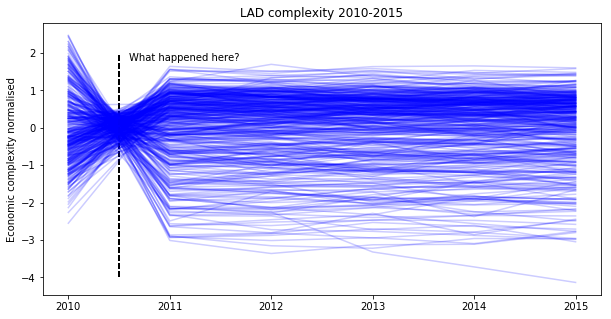

In [8]:
#We also observe some serious volatility in the complexity series
compl = [Complexify(x).get_econ_complexity(spec_threshold=1) for x in idbr_dfs]
compl_df = pd.concat(compl,axis=1).apply(lambda x: zscore(x))

fig,ax = plt.subplots(1,figsize=(10,5))
for i in np.arange(0,len(compl_df)):
    ax.plot(np.arange(0,len(compl_df.columns)),
            compl_df.ix[i,:],color='blue',alpha=0.2)
    
    ax.set_ylabel('Economic complexity normalised')
    ax.set_xticklabels(np.arange(2009,2016))
    ax.set_title('LAD complexity 2010-2015')
    
    ax.vlines(0.5,-4,2,linestyle='dashed')
ax.annotate('What happened here?',(0.6,1.8))

### Exploration of the issue
We have explored the issue and decided to set a threshold before 1 which captures significant activity in an industry in a location. When we do this, the results become more intuitive.

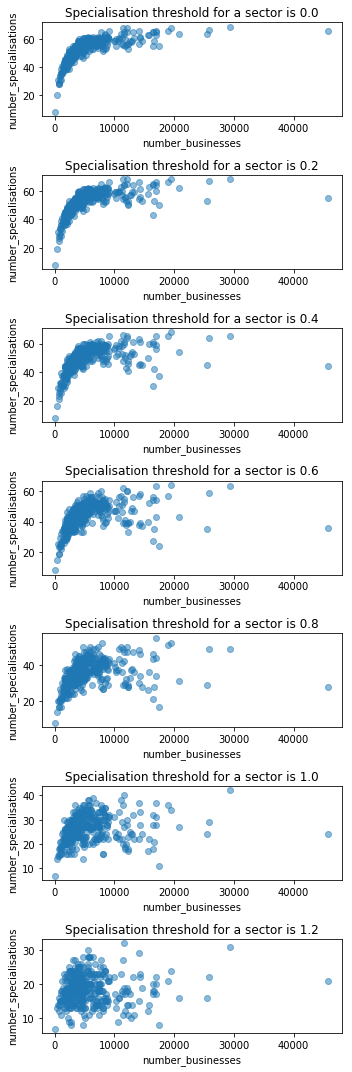

In [9]:
def binarise(x,t):
    '''
    Function that binarises a df if its values go above a certain threshold
    '''
    out = 1 if x>t else 0
    return(out)

#Compare the link between number of businesses in the area and number of specialisations 
#at different levels of resolution

#Extract total number of businesses (we focus on the latest period)
tot_businesses = idbr_dfs[5].sum(axis=1)

thres = np.linspace(0,12,7)

#Number of sectors with specialisation for 6 values of specialisation threshold (0 to 1.2)
spec_n = [create_lq_df(idbr_dfs[5]).applymap(lambda x: binarise(x,t=t/10)).sum(axis=1) for t in thres]
          

fig,ax = plt.subplots(ncols=1,nrows=len(spec_n),figsize=(5,15))

for i in np.arange(len(spec_n)):
    my_s = spec_n[i]
    ax[i].scatter(tot_businesses,my_s,alpha=0.5)
    ax[i].set_xlabel('number_businesses')
    ax[i].set_ylabel('number_specialisations')
    ax[i].set_title('Specialisation threshold for a sector is {t}'.format(t=np.round(thres[i]/10,2)))
    
plt.tight_layout()

The Relationship between economy size and number of specialisations seems to get more volatile as we set a higher threshold, whis is implausible.

In [10]:
#Compare with the outputs when we use threshold = 0.8

area_results_thres_2 = Complexify(idbr_dfs[5]).get_econ_complexity(spec_threshold=0.8)
print(area_results_thres_2.sort_values(ascending=False)[:10])

print('\n')
sect_results_thres_2 = Complexify(idbr_dfs[5]).get_sector_uniqueness(spec_threshold=0.8)
print(sect_results_thres_2.sort_values(ascending=False)[:10])

lad_name
Lambeth                 3.031346
City of London          2.856416
Wandsworth              2.831026
Camden                  2.731751
Westminster             2.689973
Islington               2.639100
St Albans               2.590883
Richmond upon Thames    2.560900
Elmbridge               2.551764
Barnet                  2.526901
Name: lad_compl, dtype: float64


cluster
services_content                3.033555
manufacture_pharmaceuticals     2.231461
services_financial_legal        2.098498
manufacture_oils                1.720215
services_professional           1.686816
services_computing              1.598478
services_human_resources        1.590127
services_kibs                   1.412589
manufacture_footwear_leather    1.316467
manufacture_light               1.298003
Name: sec_uniq, dtype: float64


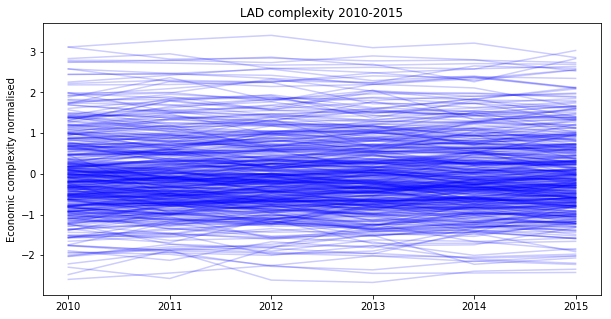

In [11]:
#The resulting series is much more stable, as we would expect

#We also observe some serious volatility in the complexity series
compl = [Complexify(x).get_econ_complexity(spec_threshold=0.8) for x in idbr_dfs]
compl_df = pd.concat(compl,axis=1).apply(lambda x: zscore(x))

fig,ax = plt.subplots(1,figsize=(10,5))
for i in np.arange(0,len(compl_df)):
    ax.plot(np.arange(0,len(compl_df.columns)),
            compl_df.ix[i,:],color='blue',alpha=0.2)
    
    ax.set_ylabel('Economic complexity normalised')
    ax.set_xticklabels(np.arange(2009,2016))
    ax.set_title('LAD complexity 2010-2015')

### What about business counts?

The volatility is worse for the BRES (employment) data than for the IDBR data. We will focus on the latter.

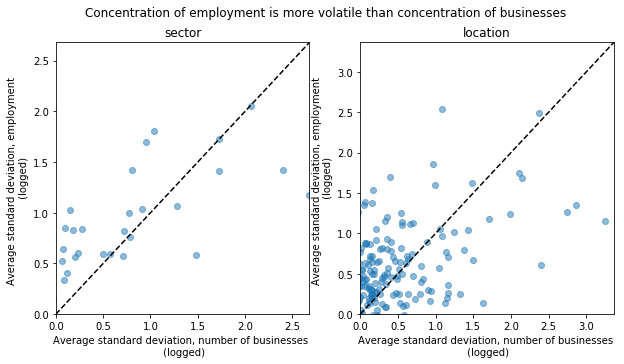

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
titles = ['sector','location']

for i in [0,1]:
    idbr_sector_std = Complexify(idbr_dfs[0]).create_lq().std(axis=i)
    bres_sector_std = Complexify(bres_dfs[0]).create_lq().std(axis=i)

    joint_df = pd.concat([idbr_sector_std,bres_sector_std],axis=1)

    ax[i].set_xlim((0,np.max(np.log(joint_df.max()))))
    ax[i].set_ylim((0,np.max(np.log(joint_df.max()))))
    
    ax[i].scatter(np.log(joint_df[0]),np.log(joint_df[1]),alpha=0.5)
    ax[i].plot([0,ax[i].get_xlim()[1]],[0,ax[i].get_ylim()[1]],color='black',ls='--')
    ax[i].set_xlabel("Average standard deviation, number of businesses \n (logged)")
    ax[i].set_ylabel("Average standard deviation, employment \n (logged)")
    
    ax[i].set_title(titles[i])
fig.suptitle("Concentration of employment is more volatile than concentration of businesses")

In [13]:
# We will focus on business counts with a threshold of 0.8

#Create datasets
bus_comp_df = pd.concat([Complexify(x).get_econ_complexity(spec_threshold=0.8) for x in idbr_dfs],axis=1)

bus_comp_df.columns = np.arange(2010,2016)

ind_uni_df = pd.concat([Complexify(x).get_sector_uniqueness(spec_threshold=0.8) for x in idbr_dfs],axis=1)

ind_uni_df.columns = np.arange(2010,2016)

In [14]:
#Create lookup codes /names

lad_codes = pd.read_csv(proc_data_path+'/lad_names_codes.csv')
welsh_lads = [x for x,y in zip(lad_codes.lad_name,lad_codes.lad_code)  if y[0]=='W' ]
scottish_lads = [x for x,y in zip(lad_codes.lad_name,lad_codes.lad_code)  if y[0]=='S' ]
ni_lads = [x for x,y in zip(lad_codes.lad_name,lad_codes.lad_code)  if y[0]=='9' ]

#Also create lookups to change things seamlessly
lad_names_to_codes = {x:y for x,y in zip(lad_codes.lad_name,lad_codes.lad_code)}
lad_codes_to_names = {y:x for x,y in zip(lad_names_to_codes.keys(),lad_names_to_codes.values())}

## 3. Predictive analysis

We create features and use them to predict future specialisation in an area.

This includes measures of activity in neighbouring areas. You can download the shapefiles to do this <a href="https://geoportal.statistics.gov.uk/Docs/Boundaries/Travel_to_Work_Areas_(UK)_2011_boundaries_(generalised_clipped)_V3.zip">here</a>


### 1. Make features

In [15]:
#Load APS data

aps_dfs = pd.read_csv(ex_data_path+'/contextual_data/aps_lad_all_yrs.csv')


#Load shapefile to create neighbour data

w = pysal.queen_from_shapefile(ex_data_path+
    "/lad_2015/Local_Authority_Districts_December_2015_Full_Clipped_Boundaries_in_Great_Britain.shp")
#Load attributes of the shapefile
lad_attr = pysal.open(
    ex_data_path+
    "/lad_2015/Local_Authority_Districts_December_2015_Full_Clipped_Boundaries_in_Great_Britain.dbf")

#Create a lookup between ids and codes
#w.neighbors
neighbor_lookup = pd.DataFrame({'id':lad_attr.by_col('OBJECTID'),
                                'code':lad_attr.by_col('LAD15CD')})
#0 indices in Python!
neighbor_lookup['id'] = neighbor_lookup['id']-1


In [16]:
#Extract specialisations and neighbour specialisation (features)
#lad specialisation
idbr_spec = [Complexify(x).create_lq() for x in idbr_dfs]

#Neighbour specialisation
idbr_neig = [extract_neighbor_specs(x) for x in idbr_spec]

#We also want to remove, for all the features, the NI lads (we don't have their shapefiles so we can't
    #include the neighbour features)
lad_sel = sorted(list(idbr_neig[0].index))

idbr_spec = [x.ix[lad_sel,:] for x in idbr_spec]

#Complexity
#Drop non ni
compl = [Complexify(x).get_econ_complexity() for x in idbr_dfs]
compl = [x[lad_sel] for x in compl]

### 2. Make output

In [17]:
#Extract outcome (specialisation gain)
idbr_spec_gain = [gain_specialisation(x,y,threshold=0) for x,y in zip(idbr_spec[:-1],
                                                                   idbr_spec[1:])]
#Drop non ni
idbr_spec_gain = [x.ix[lad_sel,:] for x in idbr_spec_gain]

### 3. Data exploration

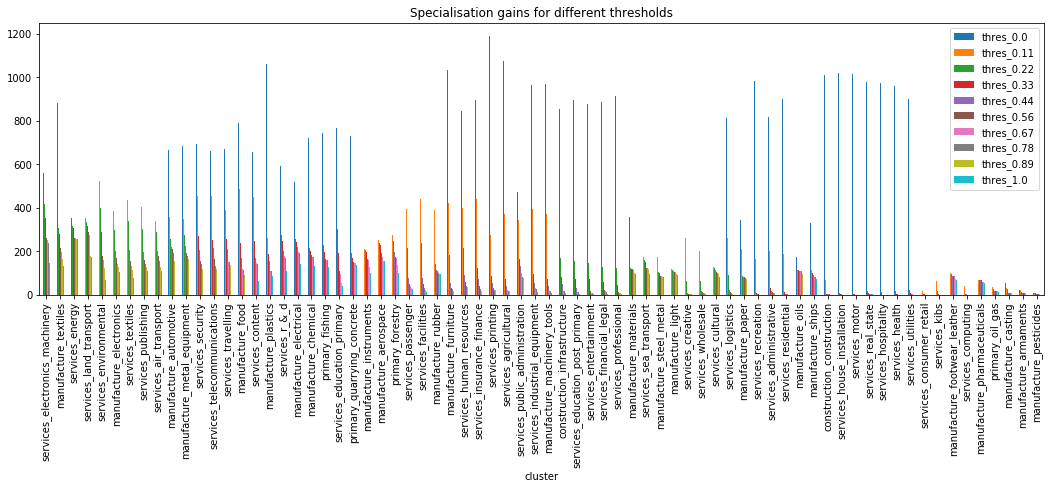

In [18]:
#Check the balance/ imbalance of different specialisations

#We can concatenate all t0s and t1s separately and then apply the gain specialisation to them
#Concatenate the t0s
t0_long_dfs = pd.concat([x for x in idbr_spec[:-1]],axis=0)

#Concatenate the t1s
t1_long_dfs = pd.concat([x for x in idbr_spec[1:]],axis=0)

#Calculate specialisation gains for different specialisation thresholds
#NB we sum over sectors

t_spec_gains_thr = pd.concat([
    gain_specialisation(t0_long_dfs,t1_long_dfs,threshold=x).sum() for x in np.linspace(0,1,10)],axis=1)

t_spec_gains_thr.columns = ['thres_'+str(np.round(x,2)) for x in np.linspace(0,1,10)]

#Sort the sectors by mean values and plot.
sector_thres_indices = t_spec_gains_thr.mean(axis=1).sort_values(ascending=False).index
#sector_thres_indices
fig, ax = plt.subplots(1,figsize=(18,5))
t_spec_gains_thr.ix[sector_thres_indices,:].plot.bar(ax=ax)

ax.set_title('Specialisation gains for different thresholds')
#ax.set_xticklabels(sector_thres_indices,size=7)

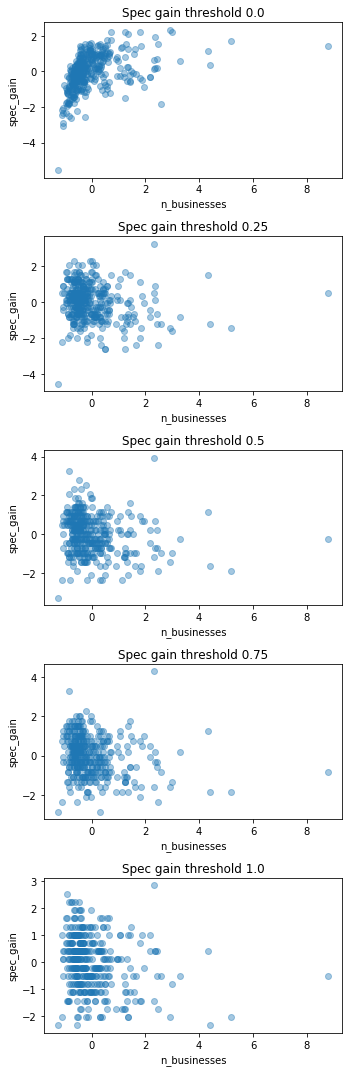

In [19]:
#Now, plot number of specialisation gains by LAD size - 
#Do the smaller locations have a greater propensity to gain specialisation - because they are smaller?

#We plot how this changes with different specialisation thresholds
#Create the thresholds
vals = np.linspace(0,1,5)

#Create the figuure and axis
fig,ax = plt.subplots(nrows=len(vals),figsize=(5,15))

for num,t in enumerate(vals):
    #Creates the sum of specialisation gains by LAD
    t_spec_gains_t = gain_specialisation(t0_long_dfs,t1_long_dfs,threshold=t).sum(axis=1)
    
    #Averages over all years
    t_spec_gains_y_av = t_spec_gains_t.reset_index(drop=False).groupby('lad_name').mean()
    
    #Plot together with sizes
    lq_robustness_plot = pd.concat([idbr_dfs[5].sum(axis=1),t_spec_gains_y_av],axis=1).dropna().apply(zscore)
    
    #if num == 1:
    #    print(lq_robustness_plot)
    lq_robustness_plot.columns = ['n_business','spec_gain_mean']

    ax[num].scatter(lq_robustness_plot.n_business,lq_robustness_plot.spec_gain_mean,alpha=0.4)
    ax[num].set_xlabel('n_businesses')
    ax[num].set_ylabel('spec_gain')
    
    ax[num].set_title('Spec gain threshold {x}'.format(x=np.round(t,2)))

plt.tight_layout()


We have the same situation as with the complexity analysis. Setting higher thresholds for specialisation gain create noise in the data

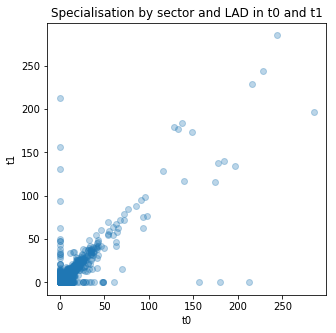

In [20]:
#spec_yoy is a df with two columns. One captures an specialisation in t0 and the other in t1
spec_yoy = pd.concat([pd.concat([pd.melt(x).set_index('cluster'),
                                pd.melt(y).set_index('cluster')],axis=1) for x,y in zip(idbr_spec[:-1],
                                                                   idbr_spec[1:])])
#Rename columns
spec_yoy.columns=['t0','t1']

fig,ax = plt.subplots(1,figsize=(5,5))

ax.scatter(spec_yoy.t0,spec_yoy.t1,alpha=0.3)

ax.set_xlabel('t0')
ax.set_ylabel('t1')

ax.set_title("Specialisation by sector and LAD in t0 and t1")

The above shows some big outliers which in some cases appear to be highly volatile (values along the axes which were very large one period and small another). We will winsorise them (Replace values above a percentile threshold with the value in that percentile)

In [21]:
#Winsorise both the specialisations and the resulting gains
idbr_spec_win = [x.apply(winsorise) for x in idbr_spec]

#Create the idbr spec gain winsorised
idbr_spec_gain_win = [gain_specialisation(x,y,threshold=0) for x,y in zip(idbr_spec_win[:-1],
                                                                   idbr_spec_win[1:])]

#Neighbour specialisation
idbr_neig_win = [extract_neighbor_specs(x) for x in idbr_spec_win]

In [22]:
#Create a simple 'transition' matrix.
spec_yoy_binary = spec_yoy.applymap(lambda x: 1 if x>1 else 0)

ct = pd.crosstab(spec_yoy_binary.t0,spec_yoy_binary.t1)
ct/np.sum(ct.sum(axis=1))*100

t1,0,1
t0,,
0,58.580409,4.408626
1,4.366959,32.644006


Similar proportions of lad/sector pairs won and lost specialisations

In [23]:
#Another quick exploration - how concentrated are the specialisation gains in different sectors?
#Calculate average number of LADs gaining specialisation in different sectors. This helps us to asses
#if our assumption about independence in development paths between periods is valid or not.
#We also want to check what are the areas that have gained more specialisation in different sectors

#Create specialisation gain panel and then calculate average gains over sector.

#First,create a column set that considers years
idbr_spec_gain_labelled = [label_columns_in_df(d,y) for d,y in zip(idbr_spec_gain, np.arange(2010,2015))]

sector_gain_tests = pd.melt(pd.concat([x for x in idbr_spec_gain_labelled],axis=1).reset_index(drop=False),id_vars='lad_name')

#How many areas gained specialisation in a single period.
sector_gain_tests['sector'] = [x.split("_p")[0] for x in sector_gain_tests['variable']]

sector_gains_grouped = sector_gain_tests.groupby('sector')




/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


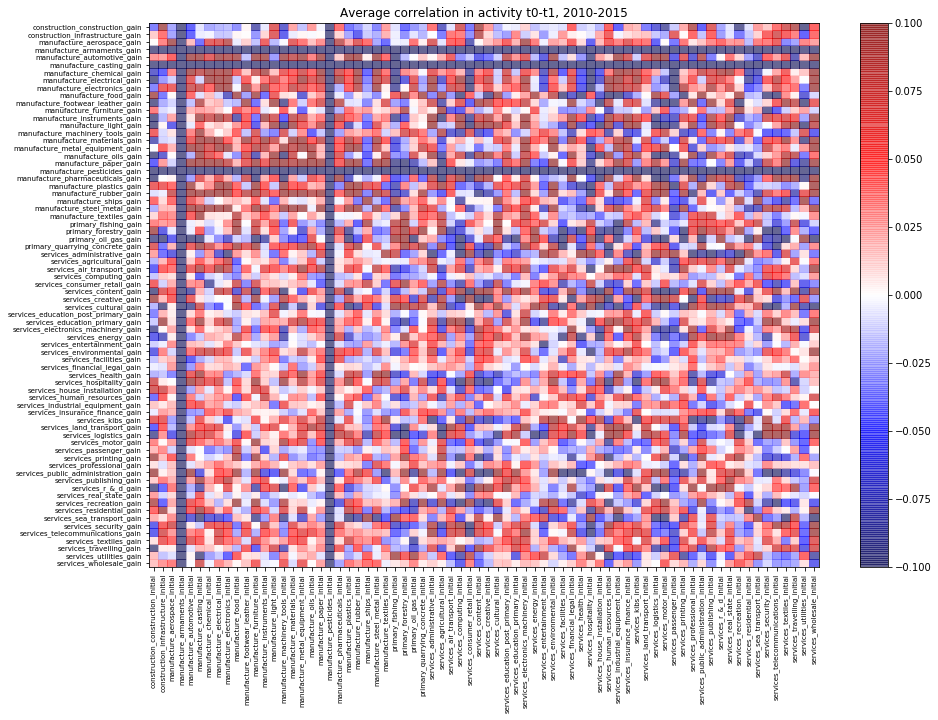

In [24]:
#Analysis of links between specialisation in period 1 and specialisation gain in period 0
sector_rels = GetHistoricalCorrelations(idbr_spec_gain_win[1:],idbr_spec_win[:-1])
sector_rels.heatmap()

NB there are a couple of sectors with ~0 values (e.g. armaments)

/usr/local/lib/python3.5/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


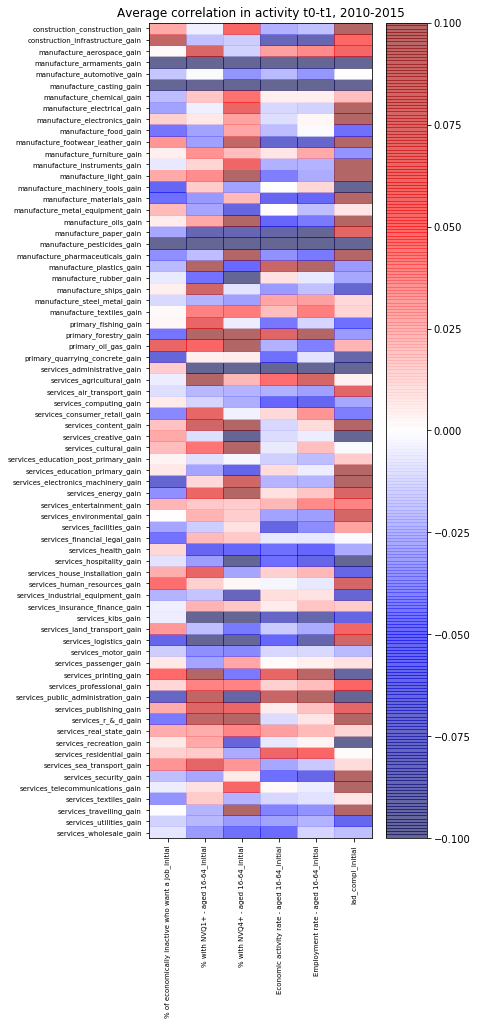

In [25]:
#Perform a similar analysis with secondary (non-sector activity) data

#Process aps for this
aps_selected = aps_dfs.set_index('lad_name').ix[lad_sel,[0,2,3,6,7,8]].groupby('year')
aps_2011_15 = [aps_selected.get_group(x).ix[:,1:] for x in list(aps_selected.groups.keys())]

#Revised - NB we are considering the period 2010-2015. Later we will remove the last year.
sec_data = [pd.concat([x,y],axis=1) for x,y in zip(aps_2011_15,compl[1:])]

#Plot
sec_rels = GetHistoricalCorrelations(idbr_spec_gain_win[2:],sec_data)
sec_rels.corr_avg()
sec_rels.heatmap(fs=(5,15))
#avg_matt = avg_mat.copy()

### 4. Produce feature sets

In [26]:
######
#4. Produce feature sets
#####

#We will create 3 feature sets and one output set.

#Before doing this, we will have to remove a couple of lads with two few labels (the Isles of Scilly and 
#Orkney Islands) and a couple of sectors with very few labels. We probably don't want to make any predictions on those.

classes_per_sample = pd.concat([
    x for x in idbr_spec_gain_win[1:]]).sum(axis=1).sort_values(ascending=False)

low_score_lads = list(set(classes_per_sample.index[classes_per_sample<5]))

lads_to_keep = sorted(list(set(classes_per_sample.index) - set(low_score_lads)))

#Do the same thing for sectors

samples_per_class = pd.concat([
    x for x in idbr_spec_gain_win[1:]]).sum().sort_values(ascending=False)

low_score_sectors = list(set(samples_per_class.index[samples_per_class<10]))
sectors_to_keep = sorted(list(set(samples_per_class.index) - set(low_score_sectors)))

#We also have some problems with the neighbours (missing data - because they have no neighbours!!)

#Finally, we need to impute missing values in APS.

X_aps_tidy = pd.concat([x.ix[lads_to_keep,:] for x in sec_data[1:]]).reset_index(drop=False)
X_aps_tidy.rename(columns={'index':'lad_name'},inplace=True)
X_aps_tidy = X_aps_tidy.groupby('lad_name')

X_aps_filled = pd.concat([
    fill_nas(X_aps_tidy.get_group(lad)) for lad in list(X_aps_tidy.groups.keys())]).set_index('lad_name')

#There is still one lad with missing data - City of London

#We drop it
still_missing = X_aps_filled.isnull().sum(axis=1).sort_values(ascending=False)

another_lad_to_drop = still_missing.index[still_missing>=1]

lads_to_keep = sorted(list(set(lads_to_keep) - set(another_lad_to_drop)))

In [27]:
#Output set:
#NB we are starting with index one because we lose one year due to lack of APS data.
Y_df = pd.concat([x.ix[lads_to_keep,sectors_to_keep] for x in idbr_spec_gain_win[2:]]).reset_index(drop=True)

#Specs
X_spec_df = pd.concat([x.ix[lads_to_keep,sectors_to_keep] for x in idbr_spec_win[2:]]).reset_index(drop=True)

#Neighbors
#We also have some problems with the neighbours (missing data - because they have no neighbours!!)
X_neig_df = pd.concat([x.ix[lads_to_keep,sectors_to_keep] for x in idbr_neig_win[2:]]).reset_index(drop=True)
X_neig_df.fillna(value=0,inplace=True)

#Secondary data
X_aps_comp_df = X_aps_filled.ix[lads_to_keep,:].reset_index(drop=True)

#We have some extra missing values here caused by low sample sizes in some responses. Replace by the average?

#Turn everything into arrays and create the dict with features

Y = np.array(Y_df)

#NB all features are normalised
feature_set_all = {'esp':np.apply_along_axis(zscore,1,np.array(X_spec_df)),
               'neigh':np.apply_along_axis(zscore,1,np.array(pd.concat([X_spec_df,X_neig_df,],axis=1))),
               'all':np.apply_along_axis(zscore,1,np.array(pd.concat([X_spec_df,X_neig_df,X_aps_comp_df],axis=1))),
               'esp_sec':np.apply_along_axis(zscore,1,np.array(pd.concat([X_spec_df,X_aps_comp_df],axis=1)))}

#Here we are removing the last 377 rows (last year) because that's what we need to use for the predictive part.
feature_set_train = {x:y[:-len(lads_to_keep),:] for x,y in zip(feature_set_all.keys(),feature_set_all.values())}

### 5. Train models

In [28]:
complete_feature_set = ModelPerformance(feature_set_train,Y)
complete_feature_set.fit_evaluate()

training nb model all
training log model all run 0
training log model all run 1
training log model all run 2
training log model all run 3
training log model all run 4
training log model all run 5
training rf model all run 0
training rf model all run 1
training rf model all run 2
training rf model all run 3
training rf model all run 4
training rf model all run 5
training rf model all run 6
training rf model all run 7
training rf model all run 8
training rf model all run 9
training rf model all run 10
training rf model all run 11
training rf model all run 12
training rf model all run 13
training rf model all run 14
training rf model all run 15
training rf model all run 16
training rf model all run 17
training nb model neigh
training log model neigh run 0
training log model neigh run 1
training log model neigh run 2
training log model neigh run 3
training log model neigh run 4
training log model neigh run 5
training rf model neigh run 0
training rf model neigh run 1
training rf model neig

In [29]:
#What are the best performing models in each specification?
complete_feature_set.best_scores

[['all', 'nb', 0.48452008963694043],
 ['esp_sec', 'rf', 10, 10, 'balanced', 0.45444111979393109],
 ['esp', 'log', 10, 'balanced', 0.50209099650410671]]

It is not very surprising that the models with balanced classes perform better: the target classes are unbalanced, so we overweight less frequent classes to generate more information about them,
It is surprising that the nb and rf models perform better with less data. Might they be overfitting/ do we have redundant information?

In [30]:
#Save models
with open(proc_data_path+'/{t}_industrial_models.p'.format(t=today),'wb') as outfile:
    pickle.dump(complete_feature_set,outfile)

### 7. Evaluate models

In [31]:
#Sector labels and lad labels
sector_labels = Y_df.columns
lad_labels = lads_to_keep

#We use the fit models 
complete_feature_set.fit_model(complete_feature_set.best_scores)

#Initialise classes for all the 'best' models we have fitted
evaluates = [ModelEvaluation(complete_feature_set.fitted_models[x],Y,complete_feature_set.fitted_features[x]) for x in ['nb','log','rf']]

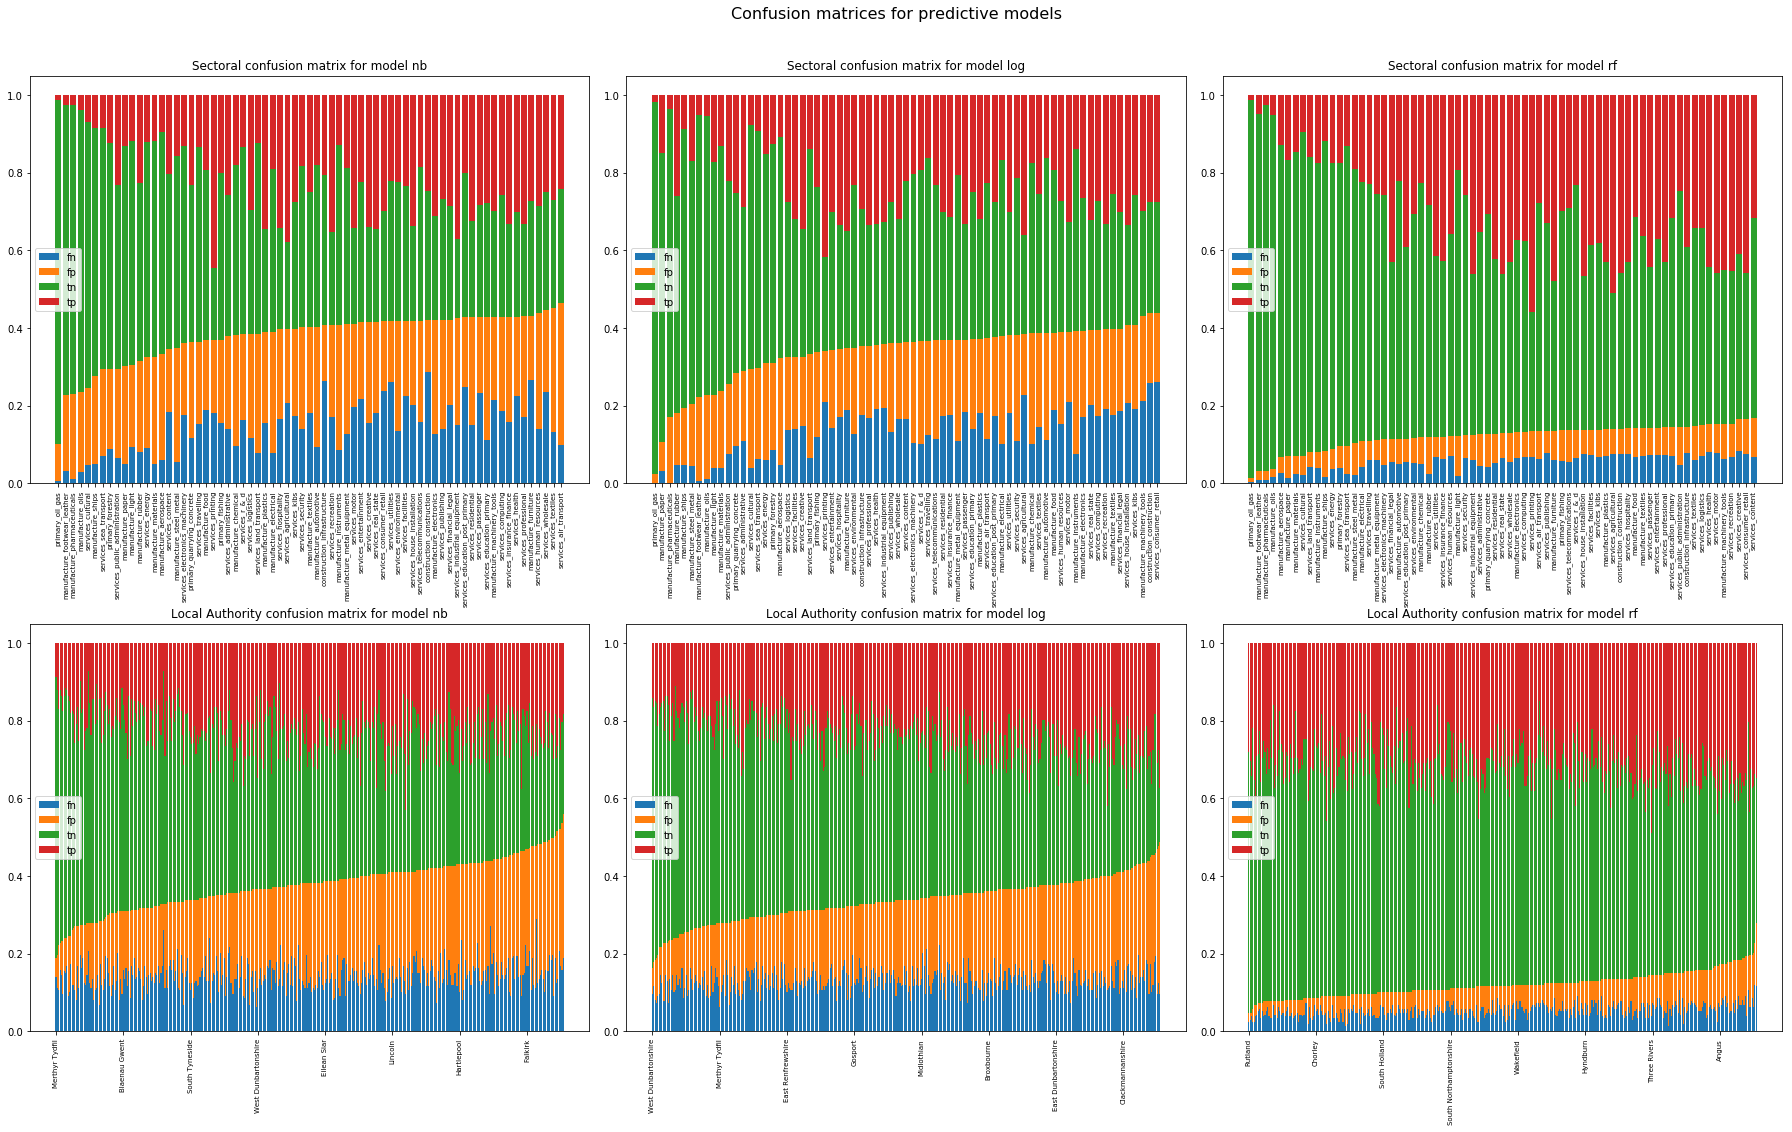

In [32]:
#Plot model performance

#Extract confusion matrices and precision_recall curves
for e in evaluates:
    e.get_confusion_matrix_sector(sector_labels)
    e.get_confusion_matrix_local(lad_labels)
    e.get_precision_recall_curves()
    
#Plot
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3,nrows=2,figsize=(25,16))

evaluates[0].plot_confusion_sector(ax1,'nb')
evaluates[0].plot_confusion_lad(ax4,'nb')

evaluates[1].plot_confusion_sector(ax2,'log')
evaluates[1].plot_confusion_lad(ax5,'log')

evaluates[2].plot_confusion_sector(ax3,'rf')
evaluates[2].plot_confusion_lad(ax6,'rf')

fig.suptitle('Confusion matrices for predictive models',size=16)

fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.savefig(fig_path+'/confusion_matrices.pdf')

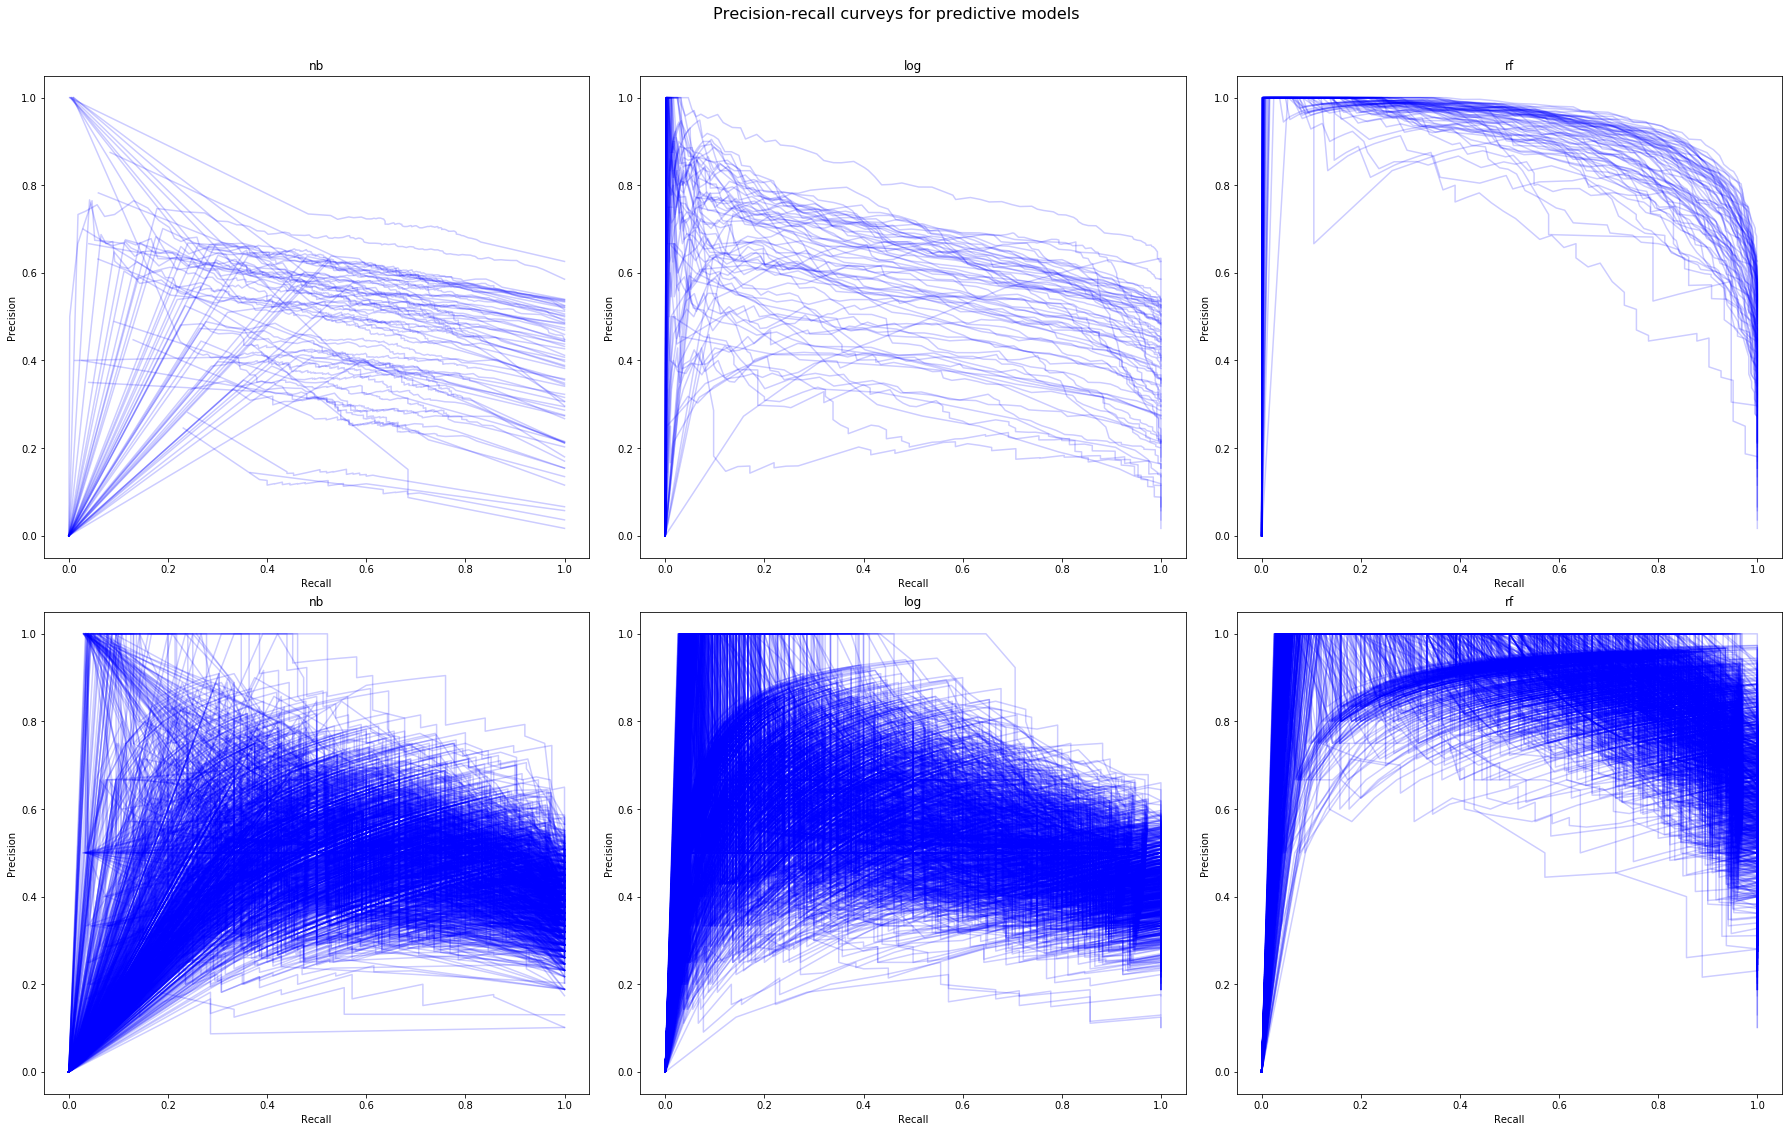

In [33]:
#Plot
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(ncols=3,nrows=2,figsize=(25,16))

evaluates[0].plot_precision_recall_curves(ax1,'nb', option='sector')
evaluates[0].plot_precision_recall_curves(ax4,'nb', option='lad')

evaluates[1].plot_precision_recall_curves(ax2,'log', option='sector')
evaluates[1].plot_precision_recall_curves(ax5,'log', option='lad')

evaluates[2].plot_precision_recall_curves(ax3,'rf', option='sector')
evaluates[2].plot_precision_recall_curves(ax6,'rf', option='lad')

fig.suptitle('Precision-recall curveys for predictive models',size=16)

fig.tight_layout()
fig.subplots_adjust(top=0.92)

plt.savefig(fig_path+'/prec_recall_curves.pdf')

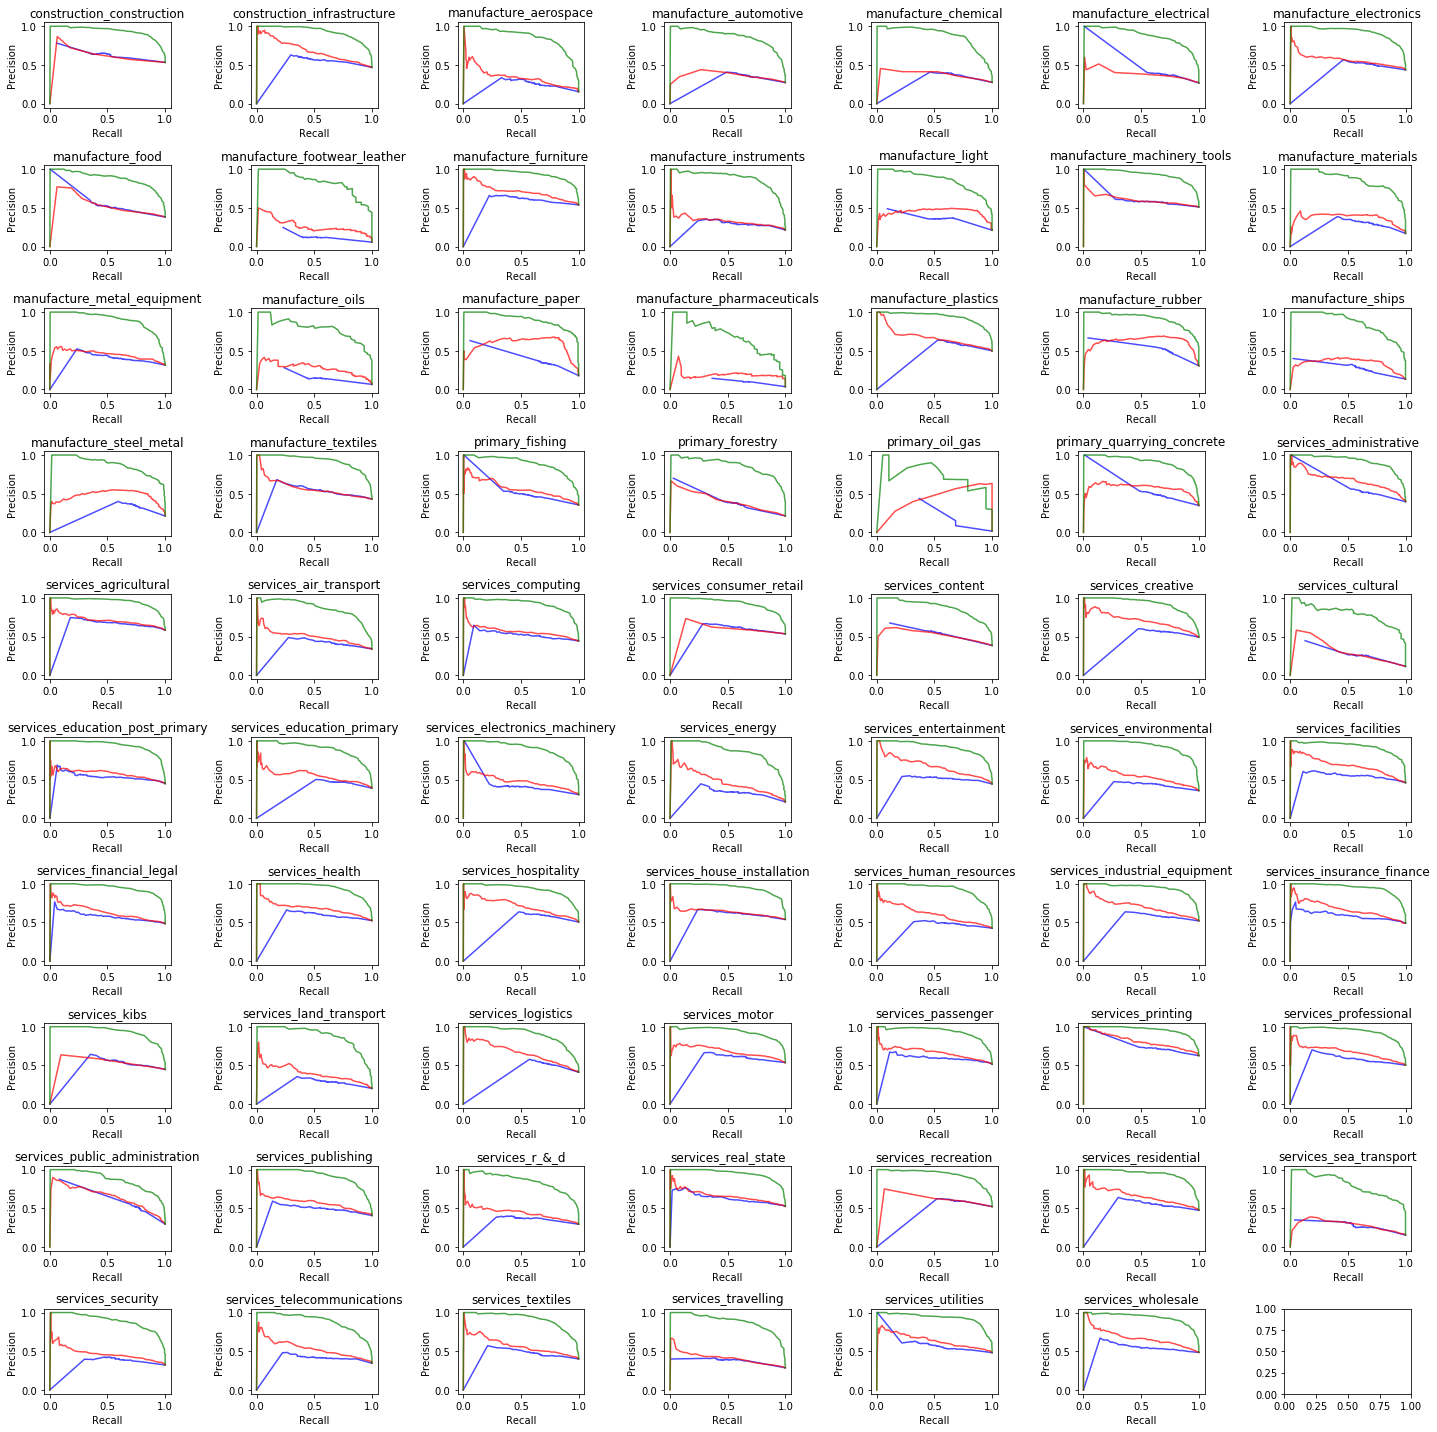

In [34]:
#Plot precision-recall by sector, and all models

mat = np.matrix(np.arange(0,70))
mat.resize((10,7))

fig,ax = plt.subplots(ncols=7,nrows=10,figsize=(20,20))

it = 0

results_nb = evaluates[0].results_sec
results_log = evaluates[1].results_sec
results_rf = evaluates[2].results_sec

for x in np.arange(len(results_nb)):
    xdim = int(np.where(mat==it)[0])
    ydim = int(np.where(mat==it)[1])

    prec_nb = [el[0] for el in results_nb[x]]
    rec_nb = [el[1] for el in results_nb[x]]
    
    prec_log = [el[0] for el in results_log[x]]
    rec_log = [el[1] for el in results_log[x]]
    
    prec_rf = [el[0] for el in results_rf[x]]
    rec_rf = [el[1] for el in results_rf[x]]
    
    #ax[xdim,ydim].plot(rec,prec)
    ax[xdim,ydim].plot(rec_nb,prec_nb,alpha=0.7,color='blue')
    ax[xdim,ydim].plot(rec_log,prec_log,alpha=0.7,color='red')
    ax[xdim,ydim].plot(rec_rf,prec_rf,alpha=0.7,color='green')
    
    ax[xdim,ydim].set_xlabel('Recall')
    ax[xdim,ydim].set_ylabel('Precision')
    ax[xdim,ydim].set_title(sector_labels[it])
    
    it +=1
    
fig.tight_layout()
plt.savefig(fig_path+'/prec_recall_sector.pdf')

### 7. Prediction

In [35]:
#Feature sets for last year
feature_set_last_y = {x:y[-len(lads_to_keep):,:] for x,y in zip(feature_set_all.keys(),feature_set_all.values())}

#Lookup between best models and feature sets
model_to_feature = {x[1]:x[0] for x in complete_feature_set.best_scores}

#Generate those predictions
future_preds = [complete_feature_set.make_prediction(
    complete_feature_set.fitted_models[x],feature_set_last_y[
        model_to_feature[x]],lads_to_keep,sectors_to_keep) for x in ['nb','rf','log']]

future_preds_averaged = (future_preds[0]+future_preds[2])/2
#future_preds_log = future_preds[2]

all_preds_categorical = generate_normalised_predictions(future_preds_averaged,idbr_dfs[5],0.25)
#all_preds_categorical.ix['Leeds',:].sort_values()

all_preds_categorical.to_csv(proc_data_path+'/categorical_predictions_all.csv')

## 3. Infogr8 outputs

In [36]:
#Some exploratory analyses

#Now to produce those bubblecharts

def Round_to_multiple(x,y):
    '''
    Rounds x to the next multiple
    
    '''
    
    num = int(np.round(x / y,0)*y)
    return(num)
    


def process_data_totals(df,y):
    '''
    This function processes a dataset very simply
    
    '''
    
    df['year']=y
    
    #df = df[['lad_name','year']+list(df.columns[1:-1])]
    
    return(df)

def Extract_economic_totals(df,var):
    '''
    This function takes a df where rows = lads (also includes years and columns) and returns
    the totals over columns (nb we are not simply applying the sum because of the string variables)
    var is a string we use to name the column
    '''
    
    out = pd.concat([df.ix[:,-1:],df.ix[:,1:].sum(axis=1)],axis=1)
    out.rename(columns={0:'{x}_totals'.format(x=var)},inplace=True)
    return(out)
    
idbr_all_ys = pd.concat([process_data_totals(d,y) for d,y in zip(idbr_dfs,np.arange(2010,2016))])
bres_all_ys = pd.concat([process_data_totals(d,y) for d,y in zip(bres_dfs,np.arange(2009,2016))])

idbr_all_ys_lq = pd.concat([process_data_totals(create_lq_df(d),y) for d,y in zip(idbr_dfs,np.arange(2010,2016))])
bres_all_ys_lq = pd.concat([process_data_totals(create_lq_df(d),y) for d,y in zip(bres_dfs,np.arange(2009,2016))])

#1. Gapminder style bubblecharts - we want to get all lad_style stats.

#Read lad and sector contextual data
lad_salary = pd.read_csv(ex_data_path+'/contextual_data/ashe_lad.csv')
lad_labour = pd.read_csv(ex_data_path+'/contextual_data/aps_lad_all_yrs.csv')

sector_gva = pd.read_csv(ex_data_path+'/contextual_data/industry_gva.csv')
sector_salary = pd.read_csv(ex_data_path+'/contextual_data/industry_income_2015.csv')

#Rename some of the dfs we have created throughout to simplify naming
lad_complexity = bus_comp_df
lad_compl_long = pd.melt(lad_complexity.reset_index(drop=False),id_vars='lad_name')
lad_compl_long.rename(columns={'variable':'year'},inplace=True)

#Employment and business counts
lad_empl = pd.concat([process_data_totals(d,y) for d,y in zip(bres_dfs,np.arange(2009,2015))])
lad_bc = idbr_all_ys

#Generate area totals
area_tots = [Extract_economic_totals(x,y) for x,y in zip([lad_empl,lad_bc],['emp','bc'])]



lad_econ_scale = pd.merge(area_tots[0].reset_index(drop=False),
                          area_tots[1].reset_index(drop=False),left_on=['lad_name','year'],
                          right_on=['lad_name','year'])


In [37]:
#Econ data

#Put bres data in a long format for merging
bres_process = pd.melt(bres_all_ys.reset_index(drop=False),id_vars=['lad_name','year'])
idbr_process = pd.melt(idbr_all_ys.reset_index(drop=False),id_vars=['lad_name','year'])

#Merge
econ_data = pd.merge(bres_process,idbr_process,
                     left_on=['lad_name','year','cluster'],
                     right_on=['lad_name','year','cluster'])

#Rename columns
econ_data.rename(columns={'value_x':'employment','cluster':'industry','value_y':'business_counts'},inplace=True)


#Now we want to get the other data.
#Annual salary, GVA pw and uniqueness.
sector_salary_df = pd.read_csv(ex_data_path+'/contextual_data/ashe_sector_all_years.csv')
sector_salary_df.rename(columns={'decile':'median_salary_decile'},inplace=True)


#Create sector uniqueness deciles for each year, melt and process for joining
sector_uni_deciles = pd.melt(ind_uni_df.apply(lambda x: pd.qcut(x,labels=False,q=10)).reset_index(drop=False),
                         id_vars='cluster',value_name='uniqueness_decile').set_index(['cluster','variable'])

#Same thing with the main df
sector_uni_df = pd.melt(ind_uni_df.reset_index(drop=False),id_vars='cluster',
                       value_name='uniqueness_score').set_index(['cluster','variable'])

#Combine
sector_uni_all_ys_df = sector_uni_df.join(sector_uni_deciles).reset_index(drop=False)
sector_uni_all_ys_df.rename(columns={'cluster':'industry','variable':'year'},inplace=True)

#Combine everything
all_econ_data = pd.merge(pd.merge(sector_salary_df.reset_index(drop=True),
                                  sector_uni_all_ys_df.reset_index(drop=True),
                                 left_on=['industry','year'],right_on=['industry','year']),
                        econ_data.reset_index(drop=True),left_on=['industry','year'],right_on=['industry','year'])


all_econ_data = all_econ_data[['lad_name','industry','year','employment','business_counts',
                               'median_salary','median_salary_decile','uniqueness_score','uniqueness_decile']]

#Now we need to merge this with the categorical predictions!
all_econ_data_preds = pd.merge(all_econ_data,
                               pd.melt(all_preds_categorical.reset_index(drop=False),
                                       id_vars='index',value_name='future_dev_prediction'),
                               left_on=['lad_name','industry'],
                               right_on=['index','variable'],how='outer')
all_econ_data_preds = all_econ_data_preds[[x for x in all_econ_data_preds.columns if x not in ['index','variable']]]
all_econ_data_preds.rename(columns={'lad_name':'location'},inplace=True)


#For the national aggregates (UK and Wales)
#We want to aggregate business count and employment and count the number of times when a sector has
#high probability of development. We create a function to do that.

def generate_agg_stats(split_df):
    agg = split_df[['business_counts','employment']].sum()
    
    ret = pd.concat([split_df[[x for x in split_df.columns if x not in ['business_counts','employment','year']]].mean(),agg],axis=0)
    ret['high_prob_lads_n'] = np.sum(split_df.ix[:,'future_dev_prediction']=='High')
    return(ret)

#Apply the above to the UK
uk_info = all_econ_data_preds.groupby(['year','industry']).apply(lambda x: generate_agg_stats(x)).reset_index(drop=False)
uk_info['location']='uk'


#Apply the above to only Wales
wales_info = all_econ_data_preds.ix[[
    x in welsh_lads for x in all_econ_data_preds.location],:].groupby(
    ['year','industry']).apply(lambda x: generate_agg_stats(x)).reset_index(drop=False)
wales_info['location']='wales'

#The lads are already done

final_df = pd.concat([uk_info,wales_info,all_econ_data_preds.ix[[
    x in welsh_lads for x in all_econ_data_preds.location],:]],axis=0)

final_df = final_df[['location','industry','year','employment','business_counts',
                     'median_salary','median_salary_decile',
                     'uniqueness_score','uniqueness_decile','high_prob_lads_n','future_dev_prediction']]

final_df.fillna(value='*',inplace=True)

#Save

import datetime
today = datetime.datetime.now()
today_date = "_".join([str(x) for x in [today.day,today.month,today.year]])

final_df.to_csv(ex_data_path+'/contextual_data/{x}_econ_trends_viz.csv'.format(x=today_date),index=False)

In [38]:
#Also want to calculate the LQs for Wales and LADs

#For LADs
#Simple - we use the idbr and bres lqs
emp_lq =  pd.melt(bres_all_ys_lq.reset_index(drop=False),id_vars=[
    'lad_name','year'],value_name='employment_lq').set_index(['lad_name','year','cluster'])
bc_lq = pd.melt(idbr_all_ys_lq.reset_index(drop=False),id_vars=[
    'lad_name','year'],value_name='business_counts_lq').set_index(['lad_name','year','cluster'])

#join them
emp_bc_lq = emp_lq.join(bc_lq).reset_index(drop=False)

#Subset by Welsh LADs
emp_bc_lq_wales_lad = emp_bc_lq.ix[[x in welsh_lads for x in emp_bc_lq.lad_name],:].dropna(0).reset_index(drop=True)

emp_bc_lq_wales_lad.head()

#Get Wales aggregate figutes. We have to do this with the all_econ_data
#Subset the variables I am interested in
all_econ_activity = all_econ_data[['lad_name','industry','year','employment','business_counts']]

#Find Welsh lads
all_econ_activity['is_wales'] = [x in welsh_lads for x in all_econ_activity['lad_name']]


#Group by is_wales, year, industry to generate totals
all_econ_activity_national = all_econ_activity.groupby([
    'is_wales','industry','year'])[['employment','business_counts']].sum().reset_index(drop=False)

#Now we want to generate LQs: 
def widen_get_lq(df,var):
    '''
    This function will spread a split df and return the lqs
    
    '''
    #Select the var (employment or business counts)

    df_wide = pd.pivot_table(df,index=['is_wales','year'],columns='industry',values=var)
    
    df_lq = create_lq_df(df_wide)
    df_lq['var'] = var+'_lq'
    
    df_lq['location'] = ['wales' if x == True else "england" for x in df_lq.index.get_level_values('is_wales')]
    
    return(df_lq)
    #return(df_lq.ix[True,:])
    

wales_lq = pd.pivot_table(pd.melt(pd.concat([widen_get_lq(all_econ_activity_national,var) for var in [
    'employment','business_counts']]).reset_index(drop=False).drop('is_wales',axis=1),id_vars=['year','var','location']),
                          index=['year','industry','location'],columns='var',values='value').reset_index(drop=False)

#Merge everything on 
emp_bc_lq_wales_lad
emp_bc_lq_wales_lad.rename(columns={'cluster':'industry','lad_name':'location'},inplace=True)

welsh_lqs = pd.concat([wales_lq,emp_bc_lq_wales_lad])

pyramid_chart_df = pd.merge(final_df,welsh_lqs,left_on=['location','industry','year'],
                      right_on=['location','industry','year'])


pyramid_chart_df.employment = pyramid_chart_df.employment.apply(lambda x: Round_to_multiple(x,100))

pyramid_chart_df.to_csv(proc_data_path+'/{x}_pyramid_chart.csv'.format(x=today_date),index=False)

pyramid_chart_df.columns

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index(['location', 'industry', 'year', 'employment', 'business_counts',
       'median_salary', 'median_salary_decile', 'uniqueness_score',
       'uniqueness_decile', 'high_prob_lads_n', 'future_dev_prediction',
       'business_counts_lq', 'employment_lq'],
      dtype='object')

In [39]:
#Data for bump chart

#It is the same as before without Wales.

#Just remove those variables that are not relevant


bump_chart_df = pyramid_chart_df[['location','industry','year','employment','business_counts','business_counts_lq',
                                 'employment_lq']]


def out_function(csv,name,date=today_date,path=proc_data_path):
    csv.to_csv(path+'/{x}_{y}.csv'.format(x=date,y=name),index=False)

out_function(bump_chart_df,'bump_chart')

In [40]:
#We want to generate aggregate stats for Wales. 
#Copy the df
all_econ_data_for_aggr = all_econ_data.copy()

#Produce the industry aggregate
all_econ_data_for_aggr['industry_agg']= [x.split("_")[0] for x in all_econ_data_for_aggr['industry']]

#Produce the Welsh dummy
all_econ_data_for_aggr['wales'] = [x in welsh_lads for x in all_econ_data_for_aggr['lad_name']]

#First extraction: aggregate by LADs, and produce total counts.
all_econ_data_lad_aggr = pd.concat([all_econ_data_for_aggr.groupby(
    ['lad_name','industry_agg','year'])[x].sum() 
                                    for x in ['employment','business_counts']],axis=1).reset_index(drop=False)

In [41]:
#Group variables by year

grouped = pd.melt(all_econ_data_lad_aggr,id_vars=['lad_name','year','industry_agg']).groupby(['year','variable'])


#Extract LQs
agg_lqs = [create_lq_df(pd.pivot_table(grouped.get_group(x).drop('year',axis=1),index='lad_name',columns='industry_agg',
               values='value')) for x in grouped.groups.keys()]

#Label LQs df
agg_lqs_cont = []

for x,tup in zip(agg_lqs,grouped.groups.keys()):
    melted = pd.melt(x.reset_index(drop=False),id_vars=['lad_name'])
    melted['variable'] = tup[1]+'_lq'
    melted['year'] = tup[0]
    agg_lqs_cont.append(melted)
    

#Concatenate them§
agg_lqs_df =pd.concat(agg_lqs_cont,axis=0)
agg_lqs_df_to_merge = pd.pivot_table(agg_lqs_df,index=['lad_name','year','industry_agg'],
                                     columns='variable',values='value')


In [42]:
#We need to merge them now
#Melt the aggregate omne
all_econ_data_lad_aggr_long = all_econ_data_lad_aggr.set_index(['lad_name','year','industry_agg'])

#Merge both
bump_aggr_lad = all_econ_data_lad_aggr_long.join(agg_lqs_df_to_merge).reset_index(drop=False)

#Select Welsh lads
bump_aggr_welsh = bump_aggr_lad.ix[[x in welsh_lads for x in bump_aggr_lad.lad_name],:].reset_index(drop=True)


bump_aggr_welsh.rename(columns={'lad_name':'location','industry_agg':'industry'},inplace=True)

In [43]:
#Do all the above for Wales
#First extraction: aggregate by LADs, and produce total counts.
all_econ_data_nat_aggr = pd.concat([all_econ_data_for_aggr.groupby(
    ['wales','industry_agg','year'])[x].sum() 
                                    for x in ['employment','business_counts']],axis=1).reset_index(drop=False)

grouped_nat = pd.melt(all_econ_data_nat_aggr,id_vars=['wales','year','industry_agg']).groupby(['year','variable'])

#Extract LQs
agg_lqs_nat = [create_lq_df(pd.pivot_table(grouped_nat.get_group(x).drop('year',axis=1),index='wales',columns='industry_agg',
               values='value')) for x in grouped_nat.groups.keys()]

#Label LQs df
agg_lqs_nat_cont = []

for x,tup in zip(agg_lqs_nat,grouped_nat.groups.keys()):
    melted = pd.melt(x.reset_index(drop=False),id_vars=['wales'])
    melted['variable'] = tup[1]+'_lq'
    melted['year'] = tup[0]
    agg_lqs_nat_cont.append(melted)
    

#Concatenate them
agg_lqs_nat_df =pd.concat(agg_lqs_nat_cont,axis=0)
agg_lqs_nat_df_to_merge = pd.pivot_table(agg_lqs_nat_df,index=['wales','year','industry_agg'],
                                     columns='variable',values='value')

#We need to merge them now
#Melt the aggregate omne
all_econ_data_nat_aggr_long = all_econ_data_nat_aggr.set_index(['wales','year','industry_agg'])

#Merge both
bump_aggr_nat = all_econ_data_nat_aggr_long.join(agg_lqs_nat_df_to_merge).reset_index(drop=False)

#Select Welsh lads
bump_aggr_nat['wales'] = ['wales' if x ==True else 'non_wales' for x in bump_aggr_nat['wales']]

bump_aggr_wales = bump_aggr_nat.ix[bump_aggr_nat['wales']=='wales',:].reset_index(drop=True)

bump_aggr_wales.rename(columns={'wales':'location','industry_agg':'industry'},inplace=True)

In [44]:
bump_chart_revised = pd.concat([bump_aggr_wales,bump_aggr_welsh,bump_chart_df],axis=0).reset_index(drop=True)

bump_chart_revised.to_csv(proc_data_path+'/bump_aggregated_df.csv',index=False)


In [45]:
#Extract findings

wales_overall_stats = bump_chart_revised.ix[(bump_chart_revised.location=='wales') &
                      ["_" not in x for x in bump_chart_revised.industry],:].groupby(
    ['industry','year'])[['employment','business_counts']].sum().reset_index(drop=False)

In [46]:
numbers_2015 = wales_overall_stats.ix[wales_overall_stats.year==2015,:]
numbers_2015['shares_emp'] = numbers_2015['employment']/numbers_2015['employment'].sum()
numbers_2015['bc_emp'] = numbers_2015['business_counts']/numbers_2015['business_counts'].sum()

numbers_2015

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,industry,year,employment,business_counts,shares_emp,bc_emp
4,construction,2015,32006,6170.0,0.025890,0.075212
9,manufacture,2015,130496,4145.0,0.105559,0.050527
14,primary,2015,4387,680.0,0.003549,0.008289
19,services,2015,1069346,71040.0,0.865002,0.865972


In [47]:
#Data for map
#It only includes the most recent year
#We want to process two datasets for bres and idbr:
#bres levels = aggregate by big sector and extract lqs and shares of activity; aggregate by small sector and
    #extract lqs. We only want this for 2010 and 2015

#idbr: same thing.


def pivot_for_map_df(df,var_name):
    '''
    Function that returns a wide df with value x year columns from a table with lads x values
    '''
    
    #What it says above
    df_wide = pd.pivot_table(
        pd.melt(df.reset_index(drop=False),id_vars=['lad_name','year'],value_name=var_name),
        index=['lad_name','cluster'],columns='year',values=var_name)
    
    #Rename columns
    df_wide.columns = [var_name+"_"+str(x) for x in df_wide.columns]
    
    #Reset indices
    #df.wide.reset_index(drop=False)
    
    return(df_wide)


def get_map_dfs(df,var_name,agg=False):
    '''
    Takes a levels df and returns a df with variables=
    lad, var_2015, share_var_2015, lq_2015, lq_2011
    
    If agg = True it generates all the stats for an industrial aggregate
    
    '''
    
    #Basic action
    #set year
    
    if agg == False:
        df = df.copy()
        df.set_index('year',inplace=True,append=True)
    
    if agg == True:
        #We need to aggregate the stats over higher level sectors.
        df = df.copy()
        df_long = pd.melt(df.reset_index(drop=False),id_vars=['lad_name','year'])
        
        #Create the sector measure
        df_long['sector'] = [x.split("_")[0] for x in df_long.cluster]
        
        #Generate the stats
        df_agg = df_long.groupby(['sector','lad_name','year'])['value'].sum().reset_index(drop=False)
        df_agg.rename(columns={'sector':'cluster'},inplace=True)
        
        #Output
        df = pd.pivot_table(df_agg,index=['lad_name','year'],columns='cluster',values='value')
        
    
    #Drop all years except 2010 and 2015
    df = df.ix[[x in [2010,2015] for x in df.index.get_level_values('year')],:]
    
    #Produce lqs (we need to do this for each year)
    df_lq = pd.concat([create_lq_df(df.ix[df.index.get_level_values('year')==val,:]) for val in [2010,2015]])
    
    #Produce shares (we are only doing this for 2015)
    df_share = df.ix[df.index.get_level_values('year')==2015,:].apply(lambda x: x/x.sum(),axis=0)
    
    #Levels: extract data using the pivot_for_map function we defined above
    df_levels = pivot_for_map_df(df,var_name=var_name)
    
    #LQs: extract data with pivot for map function
    df_lqs = pivot_for_map_df(df_lq,var_name=var_name+'_lq')
    
    #Shares - same thing
    df_shares = pivot_for_map_df(df_share,var_name=var_name+'_shares')
    
    
    #Combine everything
    df_out = df_levels.join(df_lqs).join(df_shares)
    
    #Return
    return(df_out.reset_index(drop=False))
    #return(df_long)
    

#Extract all data
emp_df = pd.concat([get_map_dfs(bres_all_ys,'employment'),
                    get_map_dfs(bres_all_ys,'employment',agg=True)])
bc_df = pd.concat([get_map_dfs(idbr_all_ys,'business_count'),
                   get_map_dfs(idbr_all_ys,'business_count',agg=True)])

map_df = pd.merge(emp_df,bc_df,left_on=['lad_name','cluster'],
                     right_on=['lad_name','cluster'])

for x in ['employment_2010','employment_2015']:
    map_df[x] = map_df[x].apply(lambda x: Round_to_multiple(x,100))
    
out_function(map_df,'map_dashboard')

In [48]:
map_df.head()

,lad_name,cluster,employment_2010,employment_2015,employment_lq_2010,employment_lq_2015,employment_shares_2015,business_count_2010,business_count_2015,business_count_lq_2010,business_count_lq_2015,business_count_shares_2015
0,Aberdeen City,construction_construction,3800,3000,0.835474,0.668743,0.004188,235,230,0.553915,0.489306,0.001942
1,Aberdeen City,construction_infrastructure,100,100,0.230153,0.142879,0.000895,15,20,0.237750,0.234268,0.000930
2,Aberdeen City,manufacture_aerospace,100,200,0.119826,0.282063,0.001767,0,5,0.000000,0.659722,0.002618
3,Aberdeen City,manufacture_armaments,0,0,0.165316,0.000000,0.000000,0,0,0.000000,0.000000,0.000000
4,Aberdeen City,manufacture_automotive,0,0,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0.000000


In [49]:
pyramid_years = pyramid_chart_df.ix[(
    pyramid_chart_df.location=="wales"),:].groupby([
    'median_salary_decile','year'])['employment'].sum().reset_index(drop=False)

pyramid_years_wide = pd.pivot_table(pyramid_years,index='median_salary_decile',columns='year',values='employment')
pyramid_years_wide['ratio'] = pyramid_years_wide[2015]/pyramid_years_wide[2011]
pyramid_years_wide

year,2011,2012,2013,2014,2015,ratio
median_salary_decile,,,,,,
0.0,386900,405900,395200,407200,407100,1.052210
1.0,41500,36900,114500,29600,34600,0.833735
2.0,120800,157800,83900,127500,129700,1.073675
3.0,167200,155000,159300,187500,191100,1.142943
4.0,69600,60600,55500,63900,60500,0.869253
5.0,60400,101900,99200,54600,75000,1.241722
6.0,194000,149700,136500,191800,168500,0.868557
7.0,65700,43500,66200,55100,59000,0.898021
8.0,60400,44600,63900,69100,69400,1.149007


In [50]:
pyramid_years_wide[2015]/pyramid_years_wide[2015].sum()

median_salary_decile
0.0    0.329342
1.0    0.027991
2.0    0.104927
3.0    0.154599
4.0    0.048944
5.0    0.060675
6.0    0.136316
7.0    0.047731
8.0    0.056144
9.0    0.031146
*      0.002184
Name: 2015, dtype: float64

In [51]:
pyramid_years_un = pyramid_chart_df.ix[(
    pyramid_chart_df.location=="wales"),:].groupby([
    'uniqueness_decile','year'])['employment'].sum().reset_index(drop=False)

In [52]:
pyramid_years_wide_un = pd.pivot_table(pyramid_years_un,index='uniqueness_decile',columns='year',values='employment')
pyramid_years_wide_un['ratio'] = pyramid_years_wide_un[2015]/pyramid_years_wide_un[2011]
pyramid_years_wide_un

year,2011,2012,2013,2014,2015,ratio
uniqueness_decile,,,,,,
0.0,73800,70100,68100,71600,88000,1.192412
1.0,279800,293900,352300,311700,360200,1.287348
2.0,194800,277600,203700,223500,182700,0.937885
3.0,247700,168800,194000,87400,90800,0.366572
4.0,44300,28100,18000,157200,148800,3.358916
5.0,50100,68200,51800,136300,42400,0.846307
6.0,109000,106400,124700,76700,114500,1.050459
7.0,77200,84600,71500,42200,86200,1.116580
8.0,20500,16600,44300,17900,27000,1.317073


In [53]:
pyramid_years_un = pyramid_chart_df.ix[(
    pyramid_chart_df.location=="wales"),:].groupby([
    'uniqueness_decile','year'])['business_counts'].sum().reset_index(drop=False)
pyramid_years_wide_un = pd.pivot_table(pyramid_years_un,index='uniqueness_decile',columns='year',values='business_counts')
pyramid_years_wide_un['ratio'] = pyramid_years_wide_un[2015]/pyramid_years_wide_un[2011]
pyramid_years_wide_un

year,2011,2012,2013,2014,2015,ratio
uniqueness_decile,,,,,,
0.0,6530.0,6245.0,6245.0,6430.0,6630.0,1.015314
1.0,25005.0,25385.0,22510.0,24685.0,21295.0,0.851630
2.0,8390.0,8815.0,10000.0,7110.0,12965.0,1.545292
3.0,6255.0,6390.0,9190.0,7220.0,8080.0,1.291767
4.0,3385.0,2965.0,1010.0,5015.0,4725.0,1.395864
5.0,4000.0,4500.0,1445.0,3910.0,2140.0,0.535000
6.0,2885.0,3020.0,5910.0,3850.0,4270.0,1.480069
7.0,3735.0,3795.0,3110.0,3560.0,9075.0,2.429719
8.0,2020.0,2090.0,5870.0,2420.0,1635.0,0.809406


In [54]:
pyramid_years = pyramid_chart_df.ix[(
    pyramid_chart_df.location=="Cardiff"),:].groupby([
    'median_salary_decile','year'])['employment'].sum().reset_index(drop=False)

pyramid_years_wide = pd.pivot_table(pyramid_years,index='median_salary_decile',columns='year',values='employment')
pyramid_years_wide['ratio'] = pyramid_years_wide[2015]/pyramid_years_wide[2011]
pyramid_years_wide

year,2011,2012,2013,2014,2015,ratio
median_salary_decile,,,,,,
0.0,63500,67300,66400,68100,69000,1.086614
1.0,8100,7100,15100,5300,5400,0.666667
2.0,13600,18400,8000,13700,14600,1.073529
3.0,21700,20600,22500,25600,26400,1.216590
4.0,7800,7900,7200,7800,8000,1.025641
5.0,7800,18200,18200,7300,9400,1.205128
6.0,36900,29400,21900,33100,33000,0.894309
7.0,15600,5300,15900,11300,13900,0.891026
8.0,17800,14100,15800,19900,18100,1.016854


In [55]:
pyramid_years = pyramid_chart_df.ix[(
    pyramid_chart_df.location=="Flintshire"),:].groupby([
    'median_salary_decile','year'])['employment'].sum().reset_index(drop=False)

pyramid_years_wide = pd.pivot_table(pyramid_years,index='median_salary_decile',columns='year',values='employment')
pyramid_years_wide['ratio'] = pyramid_years_wide[2015]/pyramid_years_wide[2011]
pyramid_years_wide

year,2011,2012,2013,2014,2015,ratio
median_salary_decile,,,,,,
0.0,18700,18600,17300,18400,18700,1.000000
1.0,1500,2000,5500,1600,1600,1.066667
2.0,9300,10500,7800,11500,11100,1.193548
3.0,6100,4300,4700,6100,5600,0.918033
4.0,4700,5400,5000,4700,5900,1.255319
5.0,6000,5500,5400,4700,4400,0.733333
6.0,9400,8000,8400,9600,8800,0.936170
7.0,3400,3800,3800,4000,3100,0.911765
8.0,3100,3000,3200,3600,4900,1.580645


In [56]:
map_wales = map_df.ix[[x in welsh_lads for x in map_df.lad_name],:]

In [57]:
sectoral_analysis = map_wales.ix[[x =='manufacture' for x in map_wales.cluster],:]
sectoral_analysis['wales_share'] = sectoral_analysis['employment_shares_2015']/sectoral_analysis['employment_shares_2015'].sum()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [58]:
sectoral_analysis[['lad_name','wales_share']].sort_values('wales_share')

,lad_name,wales_share
27657,Conwy,0.008521
27597,Ceredigion,0.009786
27381,Anglesey,0.017748
28297,Pembrokeshire,0.018966
27913,Gwynedd,0.019909
28133,Merthyr Tydfil,0.021840
27713,Denbighshire,0.022499
28169,Monmouthshire,0.025656
27469,Blaenau Gwent,0.029763
28677,The Vale of Glamorgan,0.031242


In [59]:
0.15+0.04+0.0765+0.069+0.058+0.056

0.4495

In [73]:
#Extract the manufacturing change data
manufacturing_cl = ['Flintshire','Wrexham','Powys','Carmarthenshire','Neath Port Talbot','Bridgend']

manufacturing_analysis =sectoral_analysis.ix[[x in manufacturing_cl for x in sectoral_analysis['lad_name']],:]

print(manufacturing_analysis['employment_2015'].sum() - manufacturing_analysis['employment_2010'].sum())
print(manufacturing_analysis['employment_2015'].sum()/manufacturing_analysis['employment_2010'].sum())


6700
1.12546816479


In [88]:
#Analysis of knowledge intensive sectors

#Identify sectors
ki_sectors = ['services_computing','services_content','services_creative','services_kibs']

#Extract business data
wales_custom_sector = map_wales.copy()

wales_custom_sector['in_sector'] = [x in ki_sectors for x in wales_custom_sector['cluster']]

wales_custom_grouped = wales_custom_sector.groupby('in_sector')[['business_count_2010','business_count_2015']].sum()

wales_custom_shares = 100*wales_custom_grouped.apply(lambda x: x/x.sum(),axis=0)

wales_custom_shares.iloc[:,1]/wales_custom_shares.iloc[:,0]

in_sector
False    0.988104
True     1.206189
dtype: float64

In [90]:
wales_custom_grouped_emp = wales_custom_sector.groupby('in_sector')[['employment_2010','employment_2015']].sum()

wales_custom_shares_emp = 100*wales_custom_grouped_emp.apply(lambda x: x/x.sum(),axis=0)

wales_custom_shares_emp

,employment_2010,employment_2015
in_sector,,
False,98.610757,98.84969
True,1.389243,1.15031


In [101]:
wales_custom_area = wales_custom_sector.ix[wales_custom_sector['in_sector']==True,:].groupby('lad_name')[['business_count_2010',
                                                                                     'business_count_2015']].sum()

wales_custom_area['change']=wales_custom_area.iloc[:,1]/wales_custom_area.iloc[:,0] 

wales_custom_area.sort_values('change',ascending=False)

,business_count_2010,business_count_2015,change
lad_name,,,
Caerphilly,240,430,1.791667
Merthyr Tydfil,50,80,1.600000
Blaenau Gwent,50,80,1.600000
Flintshire,420,655,1.559524
"Rhondda, Cynon, Taff",375,555,1.480000
The Vale of Glamorgan,485,710,1.463918
Conwy,285,415,1.456140
Cardiff,1400,2020,1.442857
Newport,405,575,1.419753


In [60]:
sectoral_analysis = map_wales.ix[[x =='manufacture' for x in map_wales.cluster],:]
sectoral_analysis['wales_share'] = sectoral_analysis[
    'business_count_2015']/sectoral_analysis['business_count_2015'].sum()
sectoral_analysis[['lad_name','wales_share']].sort_values('wales_share')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,lad_name,wales_share
28133,Merthyr Tydfil,0.006031
27469,Blaenau Gwent,0.010856
27381,Anglesey,0.016888
28201,Newport,0.028951
27597,Ceredigion,0.028951
28697,Torfaen,0.030157
27657,Conwy,0.031363
27713,Denbighshire,0.032569
28177,Neath Port Talbot,0.037394
28677,The Vale of Glamorgan,0.041013


In [61]:
#Extract the business counts for the period 2011-2015
idbr_check = [read_process_idbr(ex_data_path+'/idbr_lad_{y}.csv'.format(y=str(x))) for x in range(2010,2016)]
rel_sics = [str(x) for x in sic_cluster_lookup.ix[sic_cluster_lookup.cluster=='services_cultural']['sic_4']]

In [62]:
idbr_check_last = idbr_check[5]

idbr_check_last.ix[idbr_check_last['lad_name']=='Cardiff',[x for x in
                                                          idbr_check_last.columns if x.split(" :")[0] in rel_sics]]


,9101 : Library and archive activities,9102 : Museum activities,9103 : Operation of historical sites and buildings and similar visitor attractions,9104 : Botanical and zoological gardens and nature reserve activities
340,0.0,0.0,0.0,0.0


In [122]:
#Some additional analysis for stories


pyramid_years_card = pyramid_chart_df.ix[(
    pyramid_chart_df.location=="Cardiff"),:].groupby([
    'median_salary_decile','year'])['employment'].sum().reset_index(drop=False)

pyramid_years_wide_card = pd.pivot_table(pyramid_years_card,index='median_salary_decile',columns='year',values='employment')



pyramid_years_wide_card.ix[
    [x>=7 for x in pyramid_years_wide_card.index if type(x)==float],2015].sum()/pyramid_years_wide_card[2015].sum()

#pyramid_years_wide_card.ix[[x<=2 for x in pyramid_years_wide_card.index if type(x)==float],2015].sum()


0.19825918762088976

In [124]:
pyramid_years_wide_card[2015].sum()

206800

In [136]:
pyramid_chart_df.ix[(pyramid_chart_df['year']==2015) &
                   (pyramid_chart_df['industry']=='services_cultural')]

,location,industry,year,employment,business_counts,median_salary,median_salary_decile,uniqueness_score,uniqueness_decile,high_prob_lads_n,future_dev_prediction,business_counts_lq,employment_lq
325,wales,services_cultural,2015,3900,55.0,23366.7,3,0.319508,6.0,5,*,1.314788,0.914519
4434,Anglesey,services_cultural,2015,0,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,0.707400
4439,Blaenau Gwent,services_cultural,2015,0,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,0.488807
4444,Bridgend,services_cultural,2015,100,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,0.284423
4449,Caerphilly,services_cultural,2015,100,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,0.737175
4454,Cardiff,services_cultural,2015,700,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,1.011697
4459,Carmarthenshire,services_cultural,2015,300,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,1.217535
4464,Ceredigion,services_cultural,2015,300,5.0,23366.7,3,0.319508,6.0,*,High,3.003354,3.368335
4469,Conwy,services_cultural,2015,200,15.0,23366.7,3,0.319508,6.0,*,High,7.385163,1.287008
4474,Denbighshire,services_cultural,2015,0,0.0,23366.7,3,0.319508,6.0,*,Low,0.000000,0.310179
